# Decision program using machine learning methods
## SparkSQL, basic features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
!pip install torch==1.13.1
!pip install tqdm==4.66.4
!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
import dhg
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import pickle
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/SPA_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 0
Number of instances with original runtime (0.01, 0.1]: 35
Number of instances with original runtime (0.1, 1]: 1638
Number of instances with original runtime (1,10]: 598
Number of instances with original runtime (10,100]: 241
Number of instances with original runtime TO: 424


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 0
Number of instances with original runtime (0.01, 0.1]: 12
Number of instances with original runtime (0.1, 1]: 2179
Number of instances with original runtime (1,10]: 461
Number of instances with original runtime (10,100]: 282
Number of instances with original runtime TO: 2


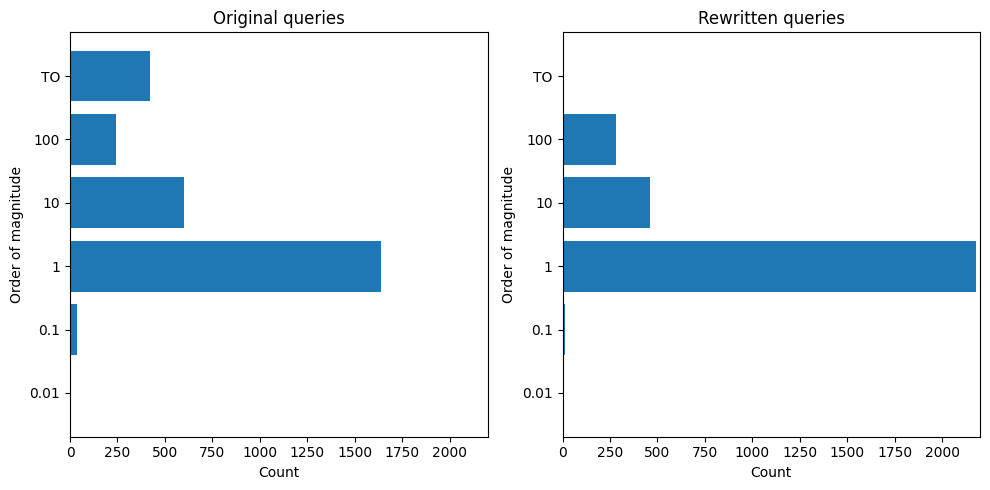

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_SPA.csv'
df = pd.read_csv(file_path)
df.head()

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text
0,STATS,001-014,orig,orig,0.215220,0.332952,2.258359,0.117732,2.043140,3,...,2,2.0,2.0,2.0,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...,"SELECT MIN(u.Id) FROM comments as c, votes as ..."
1,STATS,001-014-augA1,orig,orig,0.343959,0.465946,2.262779,0.121988,1.918820,3,...,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]",b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...,"SELECT MIN(c.id) FROM comments as c, votes as ..."
2,STATS,001-014-augA2,orig,orig,0.241465,0.358131,2.176462,0.116667,1.934997,3,...,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]",b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...,"SELECT MIN(v.id) FROM comments as c, votes as ..."
3,STATS,001-014-augF1,orig,orig,0.223958,0.286062,2.118357,0.062104,1.894398,3,...,2,2.0,2.0,2.0,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...,"SELECT MIN(u.Id) FROM comments as c, votes as ..."
4,STATS,001-014-augF1-augA1,orig,orig,0.258606,0.327809,2.182811,0.069203,1.924205,3,...,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]",b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...,"SELECT MIN(c.id) FROM comments as c, votes as ..."


In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
c

Transform the hypergraph, which is saved as pickle object, back to a dhg hypergraph object.

In [8]:
df["hypergraph"] = df["hypergraph"].apply(lambda x: pickle.loads(eval(x)))

#### Delete those examples, where both methods gave a timeout

In [9]:
df[df["orig/rewr(mean)"] == "-"]

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text
2092,SNAP,wiki-path08,-,-,100.0,100.0,100.0,0.0,0.0,9,...,2,1.142857,1.0,1.0,1.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 2]","Hypergraph(num_v=18, num_e=9)","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2093,SNAP,wiki-path08-augA1,-,-,100.0,100.0,100.0,0.0,0.0,9,...,2,1.142857,1.0,1.0,1.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 2]","Hypergraph(num_v=18, num_e=9)","select MIN(p2.fromnode) from wiki p1, wiki p2,..."


For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [10]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2934, 31)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [11]:
X = df.iloc[:, 9:26]
X.head()

,#relations,#conditions,#filters,#joins,depth,min(container counts),max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors)
0,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0
1,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
2,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
3,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0
4,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0


Get the feature matrix, which additionally includes the hypergraph information/representation.

In [12]:
X_hg = pd.concat([X, df.iloc[:,29]], axis = 1)
X_hg.head()

,#relations,#conditions,#filters,#joins,depth,min(container counts),max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors),hypergraph
0,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0,"Hypergraph(num_v=17, num_e=3)"
1,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,"Hypergraph(num_v=17, num_e=3)"
2,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,"Hypergraph(num_v=17, num_e=3)"
3,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0,"Hypergraph(num_v=17, num_e=3)"
4,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,"Hypergraph(num_v=17, num_e=3)"


#### Log-transformations

This basic features do not need log transformations.

In [13]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

,Min,Max,Diff
#relations,2.000000,11.0,9.000000
#conditions,2.000000,20.0,18.000000
#filters,0.000000,16.0,16.000000
#joins,1.000000,12.0,11.000000
depth,1.000000,7.0,6.000000
min(container counts),1.000000,1.0,0.000000
max(container counts),2.000000,5.0,3.000000
mean(container counts),1.047619,1.6,0.552381
q25(container counts),1.000000,1.0,0.000000
median(container counts),1.000000,1.0,0.000000


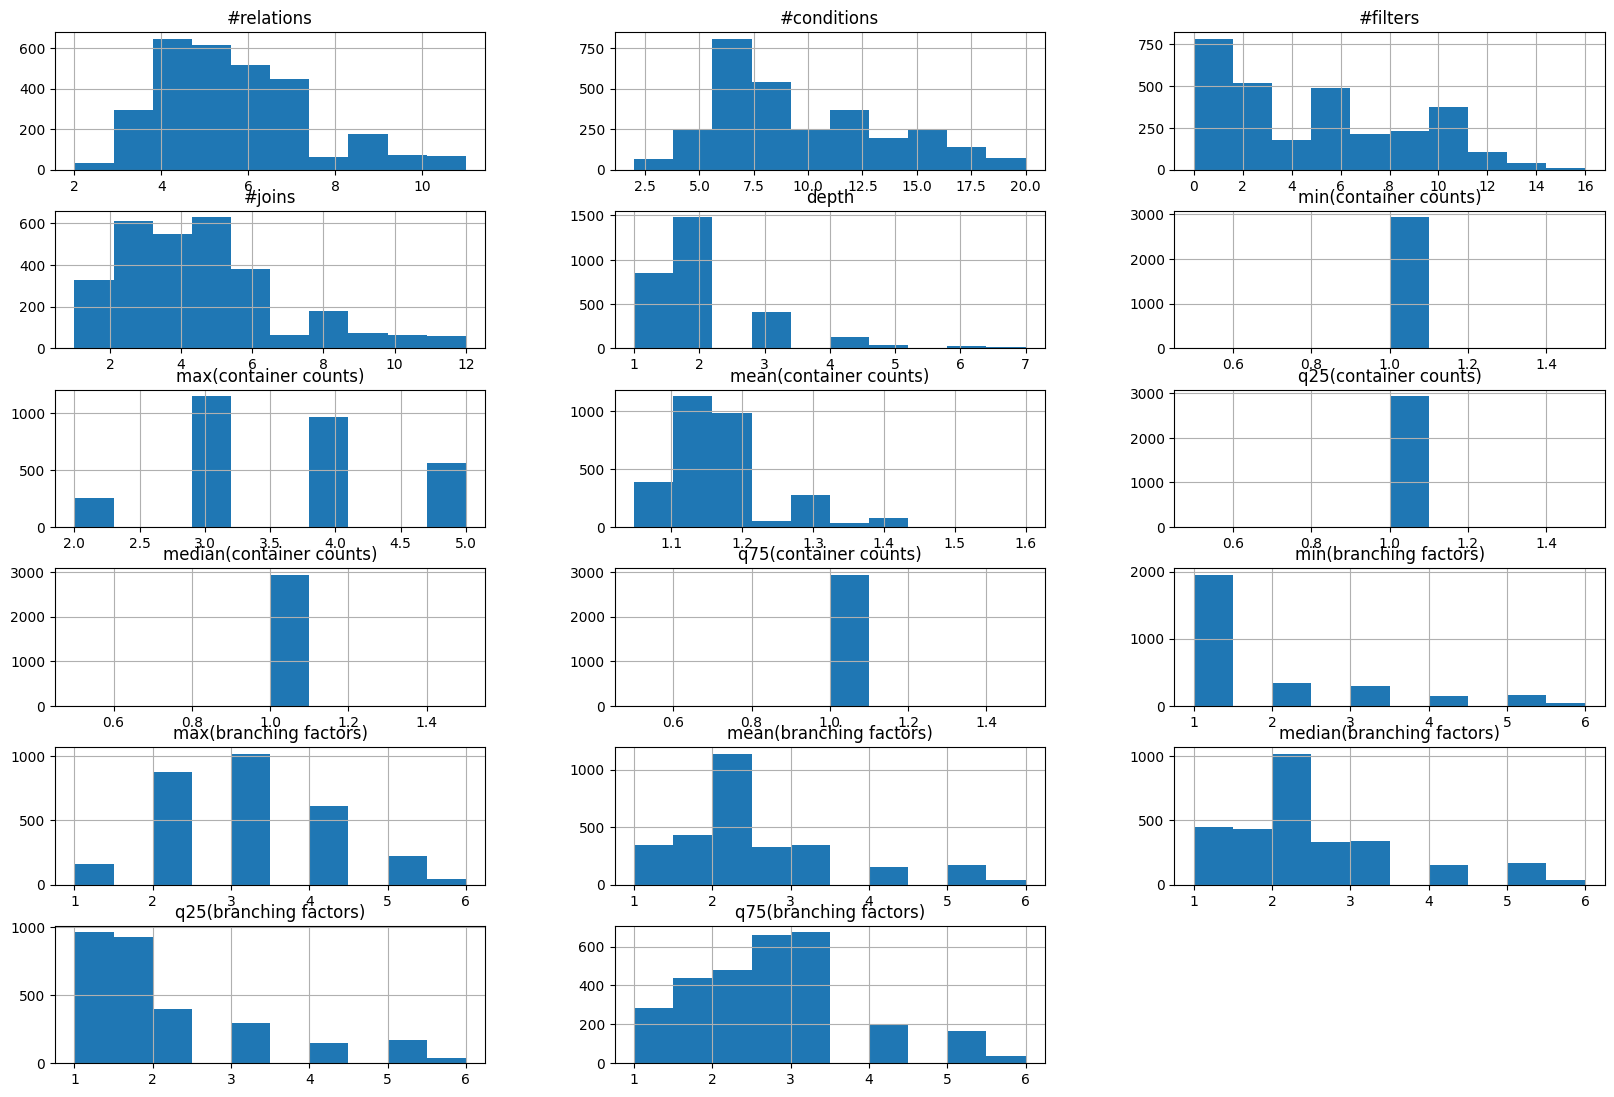

In [14]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

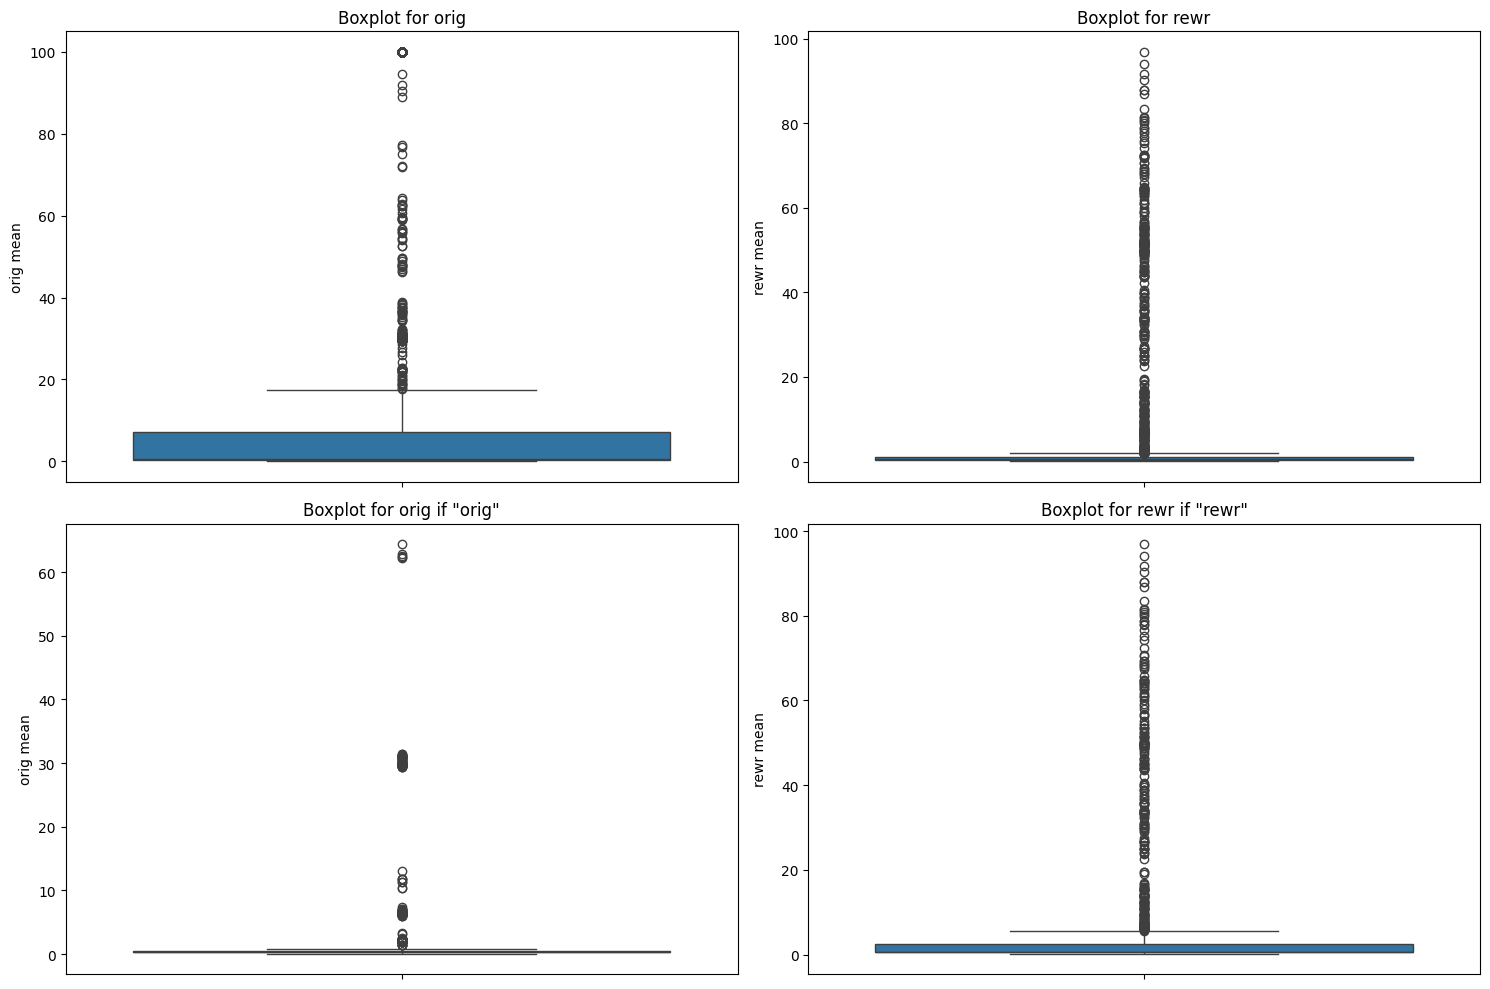

In [15]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

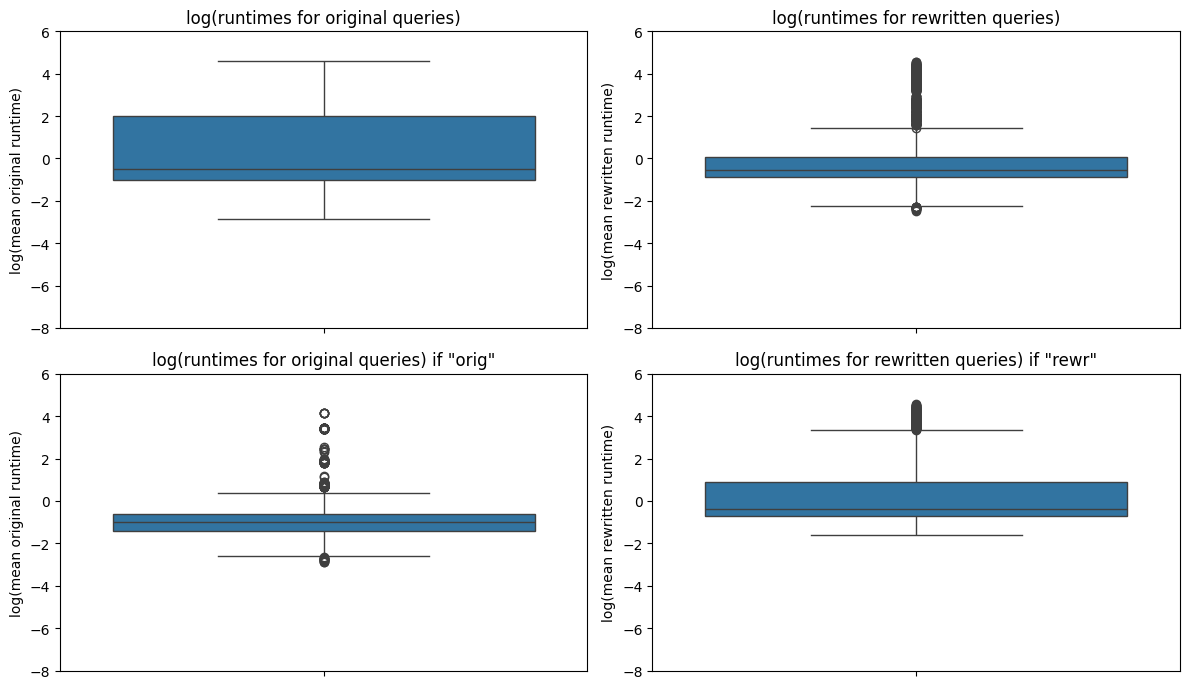

In [16]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

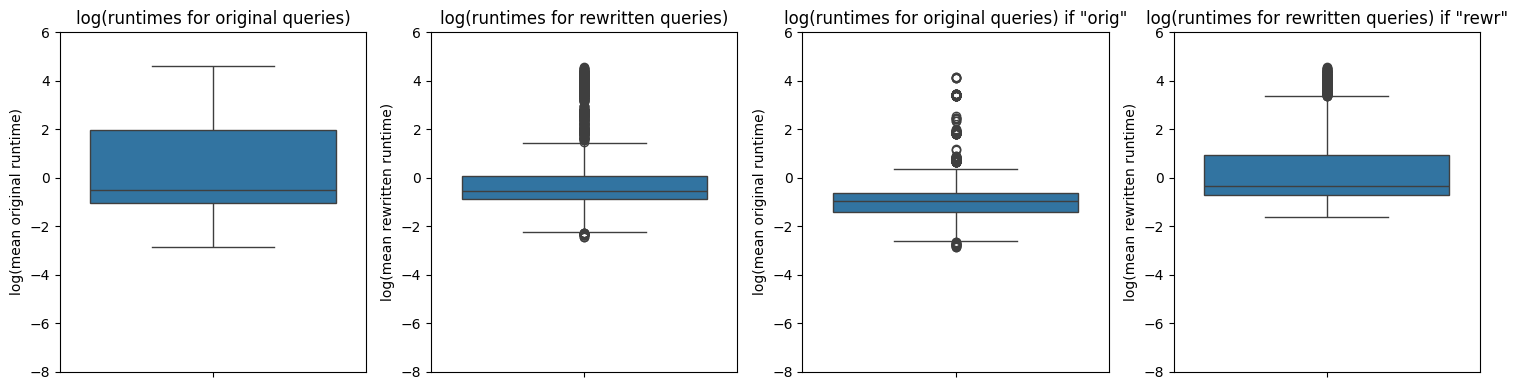

In [17]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

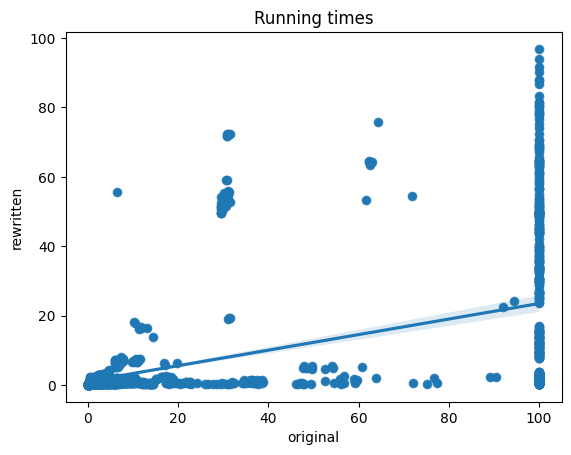

In [18]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

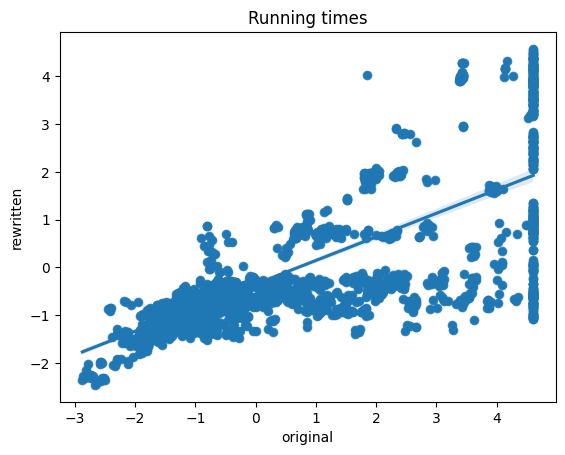

In [19]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [20]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [21]:
y1.value_counts()

orig/rewr(mean)
1    1482
0    1452
Name: count, dtype: int64

In [22]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1452
rewr     1482
equal       -
dtype: object

In [23]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
rewr    1482
orig    1452
Name: count, dtype: int64

#### Classification response with three cases

In [24]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [25]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [26]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [27]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [28]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [29]:
count_001

orig/rewr/equal 0.01
rewr     1444
orig     1412
equal      78
Name: count, dtype: int64

In [30]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

,2 classes,3 classes (0.01),3 classes (0.05),3 classes (0.1),3 classes (0.5)
orig,1452,1412,1146,726,104
rewr,1482,1444,1351,1260,1028
equal,-,78,437,948,1802


In [31]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [32]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0   -1
1   -1
2   -1
3    0
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [33]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.05, dtype: int64

In [34]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [35]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

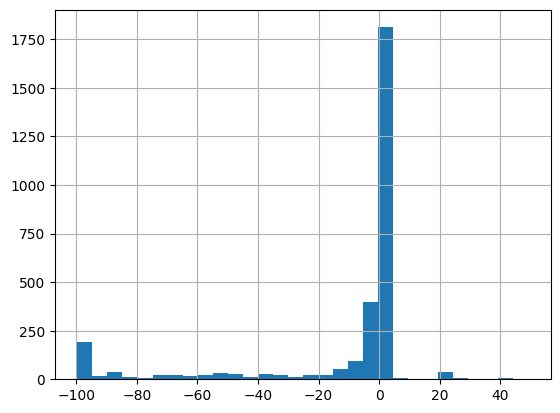

In [36]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

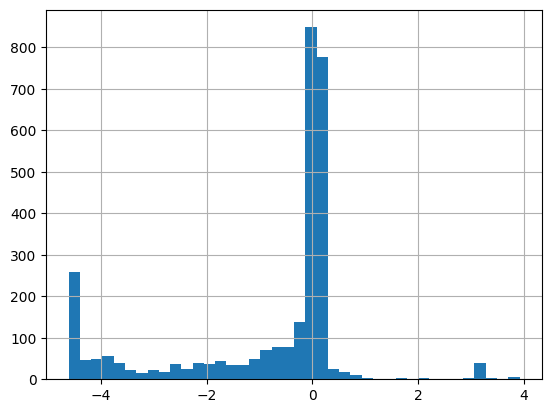

In [37]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

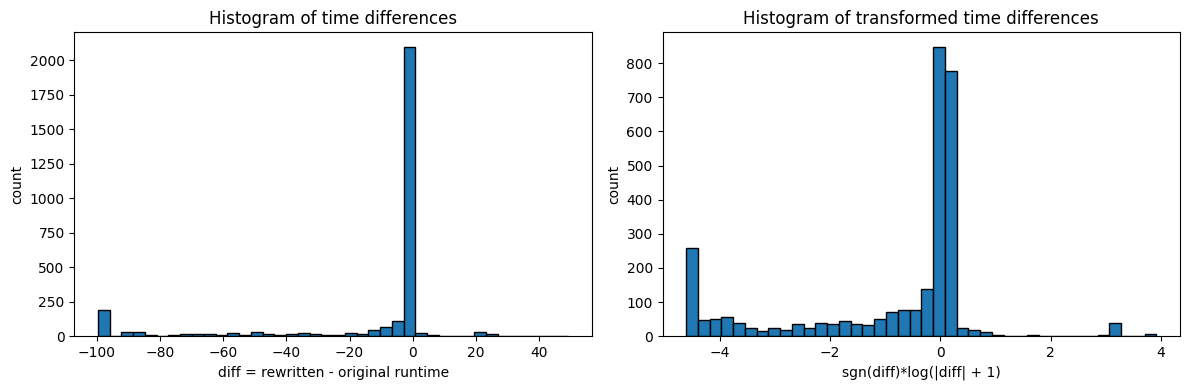

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [39]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
X_train_hg = X_hg.loc[X_train.index]
X_val_hg = X_hg.loc[X_val.index]
X_test_hg = X_hg.loc[X_test.index]
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [40]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

In [45]:
model = RandomForestRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mse)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mae)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree_reg)
print(r2)

0.5845552127457475
0.39209779798784195
0.8171307829779844


In [46]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.7952218430034129
0.6824324324324325


array([[132,  13],
       [ 47, 101]])

In [47]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.7952218430034129
0.6824324324324325


array([[132,  13],
       [ 47, 101]])

In [48]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.8464163822525598
0.8378378378378378


array([[124,  21],
       [ 24, 124]])

## ML models

In [41]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [42]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [43]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[121,  24],
       [ 26, 122]])

CV:

In [44]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [45]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1035,  272],
       [ 254, 1079]])

Adding the values to the result table:

In [46]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452


### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [47]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [48]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[  8,   3,   1],
       [  1, 166,  14],
       [  0,  21,  79]])

CV:

In [49]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [50]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[  70,   19,    7],
       [  26, 1449,  144],
       [   8,  206,  711]])

Adding the values to the result table:

In [51]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604


##### equal cut off: 0.1

Train-test split:

In [52]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [53]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[ 41,  22,   7],
       [ 17,  70,  16],
       [  7,  11, 102]])

CV:

In [54]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [55]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[415, 163,  77],
       [131, 576, 148],
       [ 75, 133, 922]])

Adding the values to the result table:

In [56]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734


##### equal cut off: 0.05

Train-test split:

In [57]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [58]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[ 91,  12,  16],
       [ 21,  14,  10],
       [ 11,   5, 113]])

CV:

In [59]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [60]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[799,  88, 149],
       [159, 133, 102],
       [171,  43, 996]])

Adding the values to the result table:

In [61]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980


##### equal cut off: 0.01

Train-test split:

In [62]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [63]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[120,   0,  22],
       [  7,   0,   2],
       [ 20,   0, 122]])

CV:

In [64]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [65]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[1028,    0,  247],
       [  35,    0,   32],
       [ 241,    3, 1054]])

Adding the values to the result table:

In [66]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431


### k-Nearest Neighbors with time difference

Train-test split:

In [67]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [68]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [69]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [70]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [71]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785


### Decision tree with two classes

Train-test split:

In [72]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [73]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[127,  18],
       [ 30, 118]])

CV:

In [74]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [75]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1060,  247],
       [ 243, 1090]])

Adding the values to the result table:

In [76]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704


### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [77]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [78]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 11,   0,   1],
       [  0, 173,   8],
       [  0,  23,  77]])

CV:

In [79]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [80]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[  74,   15,    7],
       [  15, 1479,  125],
       [   0,  196,  729]])

Adding the values to the result table:

In [81]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156


##### equal cut off: 0.1

Train-test split:

In [82]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [83]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[ 47,  17,   6],
       [ 18,  70,  15],
       [  3,  10, 107]])

CV:

In [84]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [85]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[426, 136,  93],
       [145, 561, 149],
       [ 58, 133, 939]])

Adding the values to the result table:

In [86]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498


##### equal cut off: 0.05

Train-test split:

In [87]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [88]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[ 99,   8,  12],
       [ 23,  14,   8],
       [ 11,   2, 116]])

CV:

In [89]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [90]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[ 796,   73,  167],
       [ 152,  129,  113],
       [ 144,   32, 1034]])

Adding the values to the result table:

In [91]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099


##### equal cut off: 0.01

Train-test split:

In [92]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [93]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[125,   0,  17],
       [  8,   0,   1],
       [ 24,   0, 118]])

CV:

In [94]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [95]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1041,    3,  231],
       [  32,    4,   31],
       [ 225,    3, 1070]])

Adding the values to the result table:

In [96]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839


### Decision tree with time difference

Train-test split:

In [97]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [98]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [99]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [100]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [101]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.796680


### Random forest with two classes

Train-test split:

In [102]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [103]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[121,  24],
       [ 25, 123]])

CV:

In [104]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [105]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1035,  272],
       [ 222, 1111]])

Adding the values to the result table:

In [106]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458


### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [107]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [108]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 11,   0,   1],
       [  0, 172,   9],
       [  0,  22,  78]])

CV:

In [109]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [110]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[  73,   16,    7],
       [  14, 1469,  136],
       [   0,  177,  748]])

Adding the values to the result table:

In [111]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472


##### equal cut off: 0.1

Train-test split:

In [112]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [113]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[ 42,  22,   6],
       [ 13,  71,  19],
       [  3,   6, 111]])

CV:

In [114]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [115]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[403, 157,  95],
       [112, 578, 165],
       [ 52, 114, 964]])

Adding the values to the result table:

In [116]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.05

Train-test split:

In [117]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [118]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[ 96,   9,  14],
       [ 19,  17,   9],
       [ 10,   2, 117]])

CV:

In [119]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [120]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[ 767,   84,  185],
       [ 139,  141,  114],
       [ 125,   31, 1054]])

Adding the values to the result table:

In [121]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.01

Train-test split:

In [122]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [123]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[119,   0,  23],
       [  7,   0,   2],
       [ 20,   0, 122]])

CV:

In [124]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [125]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[1011,    5,  259],
       [  28,    2,   37],
       [ 206,    1, 1091]])

Adding the values to the result table:

In [126]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


### Random forest with time difference

Train-test split:

In [127]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [128]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [129]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [130]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [131]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.796680
Random forest,0.584555,0.392098,0.817131,0.613710,0.435071,0.796384


### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [132]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [133]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[124,  21],
       [ 73,  75]])

CV:

In [134]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [135]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1066,  241],
       [ 593,  740]])

Adding the values to the result table:

In [136]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139


### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [137]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [138]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[  7,   4,   1],
       [  0, 173,   8],
       [  0,  49,  51]])

CV:

In [139]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [140]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  61,   25,   10],
       [  11, 1528,   80],
       [   1,  491,  433]])

Adding the values to the result table:

In [141]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.1

Train-test split:

In [142]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [143]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[28, 28, 14],
       [15, 61, 27],
       [10, 30, 80]])

CV:

In [144]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [145]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[241, 248, 166],
       [ 84, 490, 281],
       [ 97, 304, 729]])

Adding the values to the result table:

In [146]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.05

Train-test split:

In [147]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [148]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[95,  0, 24],
       [26,  0, 19],
       [45,  0, 84]])

CV:

In [149]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [150]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[777,   0, 259],
       [249,   0, 145],
       [423,   0, 787]])

Adding the values to the result table:

In [151]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.01

Train-test split:

In [152]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [153]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[119,   0,  23],
       [  5,   0,   4],
       [ 63,   0,  79]])

CV:

In [154]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [155]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1040,    0,  235],
       [  34,    0,   33],
       [ 547,    0,  751]])

Adding the values to the result table:

In [156]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


### SVM with time difference, linear kernel

Train-test split:

In [157]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [158]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [159]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [160]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [161]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.796680
Random forest,0.584555,0.392098,0.817131,0.613710,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305


### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [162]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [163]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[125,  20],
       [ 69,  79]])

CV:

In [164]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [165]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1115,  192],
       [ 561,  772]])

Adding the values to the result table:

In [166]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145


### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [167]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [168]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[  7,   4,   1],
       [  0, 178,   3],
       [  0,  52,  48]])

CV:

In [169]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [170]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  54,   36,    6],
       [   0, 1587,   32],
       [   0,  526,  399]])

Adding the values to the result table:

In [171]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.1

Train-test split:

In [172]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [173]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[24, 33, 13],
       [10, 64, 29],
       [ 1, 31, 88]])

CV:

In [174]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [175]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[249, 267, 139],
       [ 75, 511, 269],
       [ 33, 295, 802]])

Adding the values to the result table:

In [176]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.05

Train-test split:

In [177]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [178]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[93,  0, 26],
       [28,  0, 17],
       [31,  0, 98]])

CV:

In [179]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [180]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[812,   0, 224],
       [233,   0, 161],
       [377,   0, 833]])

Adding the values to the result table:

In [181]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.01

Train-test split:

In [182]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [183]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[123,   0,  19],
       [  7,   0,   2],
       [ 62,   0,  80]])

CV:

In [184]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [185]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1083,    0,  192],
       [  41,    0,   26],
       [ 518,    0,  780]])

Adding the values to the result table:

In [186]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


### SVM with time difference, polynomial kernel

Train-test split:

In [187]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [188]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [189]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [190]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [191]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.796680
Random forest,0.584555,0.392098,0.817131,0.613710,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.815210,0.749433,0.397751


### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [192]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [193]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[133,  12],
       [ 72,  76]])

CV:

In [194]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [195]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1175,  132],
       [ 632,  701]])

Adding the values to the result table:

In [196]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145
SVM rbf,0.713311,0.513514,0.710606,0.525881


### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [197]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [198]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[  7,   4,   1],
       [  0, 170,  11],
       [  0,  43,  57]])

CV:

In [199]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [200]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  54,   36,    6],
       [   0, 1476,  143],
       [   0,  422,  503]])

Adding the values to the result table:

In [201]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.1

Train-test split:

In [202]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [203]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[25, 34, 11],
       [ 9, 69, 25],
       [ 2, 27, 91]])

CV:

In [204]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [205]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[258, 296, 101],
       [ 78, 571, 206],
       [ 41, 334, 755]])

Adding the values to the result table:

In [206]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.05

Train-test split:

In [207]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [208]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[108,   1,  10],
       [ 31,   1,  13],
       [ 54,   0,  75]])

CV:

In [209]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [210]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[915,   2, 119],
       [264,  16, 114],
       [516,   1, 693]])

Adding the values to the result table:

In [211]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


##### equal cut off: 0.01

Train-test split:

In [212]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [213]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[131,   0,  11],
       [  7,   0,   2],
       [ 67,   0,  75]])

CV:

In [214]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [215]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1157,    0,  118],
       [  43,    0,   24],
       [ 602,    0,  696]])

Adding the values to the result table:

In [216]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.863481,0.863481,0.791265,0.844697,0.844697,0.797604
5-NN 0.1,0.726962,0.726962,0.705109,0.724621,0.724621,0.707734
5-NN 0.05,0.744027,0.744027,0.650595,0.730303,0.730303,0.643980
5-NN 0.01,0.825939,0.825939,0.568075,0.788636,0.788636,0.539431
Decision tree 0.5,0.890785,0.890785,0.880823,0.864394,0.864394,0.824156
Decision tree 0.1,0.764505,0.764505,0.747569,0.729545,0.729545,0.712498
Decision tree 0.05,0.781570,0.781570,0.680756,0.742045,0.742045,0.650099
Decision tree 0.01,0.829352,0.829352,0.570423,0.801136,0.801136,0.566839
Random forest 0.5,0.890785,0.890785,0.882314,0.867424,0.867424,0.825472
Random forest 0.1,0.764505,0.764505,0.738107,0.736742,0.736742,0.714796


### SVM with time difference, rbf kernel

Train-test split:

In [217]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [218]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [219]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [220]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [221]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.796680
Random forest,0.584555,0.392098,0.817131,0.613710,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.815210,0.749433,0.397751
SVM rbf,1.612341,0.692069,0.495604,1.666438,0.727603,0.447111


### Deep MLP with two classes

In [222]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [223]:
def MLP_classification(X_training, y_training, X_validation, y_validation, type, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

    mlp = MLPClassifier(random_seed=20)

    loss_function = nn.CrossEntropyLoss()  
        
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            targets = targets.long()  # Convert target tensor to torch.long data type
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data).squeeze()
            val_targets = val_targets.long()
            val_loss = loss_function(val_outputs, val_targets).item()
            #print(f'Validation loss: {val_loss}')
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    print("Training has completed")


    mlp2 = MLPClassifier(random_seed=20)
    mlp2.load_state_dict(best_model_state)
    
    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data).squeeze()
        predicted_labels = torch.argmax(outputs, dim=1).numpy()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)

    if type == "2_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall = recall_score(val_targets, predicted_labels)
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall_micro = recall_score(val_targets, predicted_labels, average='micro')
        recall_macro = recall_score(val_targets, predicted_labels, average='macro')
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 2

In [224]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [225]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-5-2")

Starting Epoch 1
0.7442948867877325
New best model found at epoch 1 with validation loss 0.5726732611656189
Starting Epoch 2
0.5795564651489258
New best model found at epoch 2 with validation loss 0.5692018866539001
Starting Epoch 3
0.576042890548706
Starting Epoch 4
0.5746120226879915
New best model found at epoch 4 with validation loss 0.5671882629394531
Starting Epoch 5
0.5736376605927944
New best model found at epoch 5 with validation loss 0.562140166759491
Starting Epoch 6
0.5719288202623526
Starting Epoch 7
0.5709182918071747
New best model found at epoch 7 with validation loss 0.5581754446029663
Starting Epoch 8
0.5688290558755398
New best model found at epoch 8 with validation loss 0.556645929813385
Starting Epoch 9
0.5699893186489741
Starting Epoch 10
0.5686919912695885
Starting Epoch 11
0.5693556070327759
New best model found at epoch 11 with validation loss 0.5561731457710266
Starting Epoch 12
0.5693189625938734
Starting Epoch 13
0.571213016907374
New best model found at epo

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 2

In [226]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [227]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-10-2")

Starting Epoch 1
0.8379995475212733
New best model found at epoch 1 with validation loss 0.5914157629013062
Starting Epoch 2
0.6187379484375318
Starting Epoch 3
0.6098581304152807
Starting Epoch 4
0.6064253052075704
New best model found at epoch 4 with validation loss 0.5783376097679138
Starting Epoch 5
0.5934111451109251
New best model found at epoch 5 with validation loss 0.5729165077209473
Starting Epoch 6
0.5937540059288343
Starting Epoch 7
0.5863025610645612
New best model found at epoch 7 with validation loss 0.5636701583862305
Starting Epoch 8
0.5773310487469038
Starting Epoch 9
0.5790330295761427
New best model found at epoch 9 with validation loss 0.5591007471084595
Starting Epoch 10
0.5742069880167643
Starting Epoch 11
0.5691543109714985
New best model found at epoch 11 with validation loss 0.5575034618377686
Starting Epoch 12
0.5687786464889845
New best model found at epoch 12 with validation loss 0.5563582181930542
Starting Epoch 13
0.5673764621218046
New best model found a

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 2

In [228]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [229]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-20-2")

Starting Epoch 1
0.8416701331734657
New best model found at epoch 1 with validation loss 0.5949550271034241
Starting Epoch 2
0.58680276821057
New best model found at epoch 2 with validation loss 0.5853022933006287
Starting Epoch 3
0.5764506608247757
New best model found at epoch 3 with validation loss 0.5711075663566589
Starting Epoch 4
0.574011966586113
New best model found at epoch 4 with validation loss 0.5667930841445923
Starting Epoch 5
0.5738399041195711
New best model found at epoch 5 with validation loss 0.5657443404197693
Starting Epoch 6
0.5726799157758554
Starting Epoch 7
0.5735275832315286
Starting Epoch 8
0.5768036283552647
Starting Epoch 9
0.5720806792378426
New best model found at epoch 9 with validation loss 0.5620625615119934
Starting Epoch 10
0.5711871211727461
Starting Epoch 11
0.5698863801856836
Starting Epoch 12
0.5696451266606649
New best model found at epoch 12 with validation loss 0.5586310625076294
Starting Epoch 13
0.5682104006409645
Starting Epoch 14
0.569491

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 2

In [230]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [231]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-25-2")

Starting Epoch 1
0.9861047118902206
New best model found at epoch 1 with validation loss 0.5878664255142212
Starting Epoch 2
0.6029275804758072
New best model found at epoch 2 with validation loss 0.578240156173706
Starting Epoch 3
0.6018370091915131
Starting Epoch 4
0.5901985242962837
New best model found at epoch 4 with validation loss 0.5651363134384155
Starting Epoch 5
0.5807055458426476
New best model found at epoch 5 with validation loss 0.5611612796783447
Starting Epoch 6
0.5781910518805186
Starting Epoch 7
0.5798015718658766
New best model found at epoch 7 with validation loss 0.5595408082008362
Starting Epoch 8
0.583001563946406
Starting Epoch 9
0.5744314876695474
Starting Epoch 10
0.5700258711973826
New best model found at epoch 10 with validation loss 0.5566468834877014
Starting Epoch 11
0.5681091174483299
Starting Epoch 12
0.5659641089538733
Starting Epoch 13
0.5643705253799757
New best model found at epoch 13 with validation loss 0.5524047017097473
Starting Epoch 14
0.5636

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 2

In [232]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [233]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-2")

Starting Epoch 1
1.485403761267662
New best model found at epoch 1 with validation loss 0.6645243763923645
Starting Epoch 2
0.6223328510920206
New best model found at epoch 2 with validation loss 0.5846708416938782
Starting Epoch 3
0.6115364183982214
Starting Epoch 4
0.6007194047172865
New best model found at epoch 4 with validation loss 0.5759806632995605
Starting Epoch 5
0.5913672174016634
Starting Epoch 6
0.5977613230546316
New best model found at epoch 6 with validation loss 0.5735726356506348
Starting Epoch 7
0.5858812009294828
Starting Epoch 8
0.588665978362163
Starting Epoch 9
0.5885333592693011
New best model found at epoch 9 with validation loss 0.5712106227874756
Starting Epoch 10
0.5823734849691391
New best model found at epoch 10 with validation loss 0.5645089149475098
Starting Epoch 11
0.5794079775611559
Starting Epoch 12
0.572603822996219
Starting Epoch 13
0.5770689360797405
Starting Epoch 14
0.5711359803875288
New best model found at epoch 14 with validation loss 0.55819

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 2

In [234]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [235]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-2")

Starting Epoch 1
1.2934865007797878
New best model found at epoch 1 with validation loss 0.6840505003929138
Starting Epoch 2
0.6151171699166298
New best model found at epoch 2 with validation loss 0.5741039514541626
Starting Epoch 3
0.5950388585527738
New best model found at epoch 3 with validation loss 0.5675252676010132
Starting Epoch 4
0.5883699854214987
New best model found at epoch 4 with validation loss 0.5637314319610596
Starting Epoch 5
0.5825260877609253
New best model found at epoch 5 with validation loss 0.563510000705719
Starting Epoch 6
0.5875357165932655
Starting Epoch 7
0.5747323061029116
New best model found at epoch 7 with validation loss 0.5534159541130066
Starting Epoch 8
0.5689612105488777
Starting Epoch 9
0.5680359850327173
New best model found at epoch 9 with validation loss 0.5510074496269226
Starting Epoch 10
0.5717062875628471
Starting Epoch 11
0.5603689427177111
Starting Epoch 12
0.5623901511232058
New best model found at epoch 12 with validation loss 0.543895

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 2

In [236]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [237]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-10-5-2")

Starting Epoch 1
0.7509863078594208
New best model found at epoch 1 with validation loss 0.585844099521637
Starting Epoch 2
0.594898983836174
New best model found at epoch 2 with validation loss 0.5722861289978027
Starting Epoch 3
0.5906402617692947
Starting Epoch 4
0.5811571379502615
New best model found at epoch 4 with validation loss 0.5702766180038452
Starting Epoch 5
0.5792363807559013
New best model found at epoch 5 with validation loss 0.5701988935470581
Starting Epoch 6
0.5784717450539271
Starting Epoch 7
0.5754518012205759
New best model found at epoch 7 with validation loss 0.569673478603363
Starting Epoch 8
0.5778265620271364
Starting Epoch 9
0.5761745820442835
New best model found at epoch 9 with validation loss 0.5676354169845581
Starting Epoch 10
0.5763514141241709
Starting Epoch 11
0.5752653715511163
New best model found at epoch 11 with validation loss 0.566676914691925
Starting Epoch 12
0.5742872431874275
Starting Epoch 13
0.5775385076800982
Starting Epoch 14
0.5759384

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 2

In [238]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [239]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-20-10-2")

Starting Epoch 1
0.7637677093346914
New best model found at epoch 1 with validation loss 0.6074227690696716
Starting Epoch 2
0.5842183157801628
New best model found at epoch 2 with validation loss 0.5692379474639893
Starting Epoch 3
0.5747722710172335
Starting Epoch 4
0.582257580012083
New best model found at epoch 4 with validation loss 0.5676413178443909
Starting Epoch 5
0.577489343782266
Starting Epoch 6
0.5740671580036482
New best model found at epoch 6 with validation loss 0.5636148452758789
Starting Epoch 7
0.5740656753381094
Starting Epoch 8
0.5726649289329847
New best model found at epoch 8 with validation loss 0.5561926364898682
Starting Epoch 9
0.5660343108077844
New best model found at epoch 9 with validation loss 0.5530290603637695
Starting Epoch 10
0.5664738317330679
New best model found at epoch 10 with validation loss 0.5517794489860535
Starting Epoch 11
0.5635304152965546
Starting Epoch 12
0.5623356935878595
Starting Epoch 13
0.5640945409735044
New best model found at e

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 2

In [240]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [241]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-20-2")

Starting Epoch 1
0.9840214525659879
New best model found at epoch 1 with validation loss 0.590629518032074
Starting Epoch 2
0.5996841316421827
New best model found at epoch 2 with validation loss 0.5677183270454407
Starting Epoch 3
0.5814636747042338
Starting Epoch 4
0.5823670489092668
Starting Epoch 5
0.5779256286720434
Starting Epoch 6
0.5759276896715164
Starting Epoch 7
0.5743923584620158
Starting Epoch 8
0.574910561243693
New best model found at epoch 8 with validation loss 0.5667933225631714
Starting Epoch 9
0.5721495350201925
Starting Epoch 10
0.5694425043960413
Starting Epoch 11
0.5738466108838717
New best model found at epoch 11 with validation loss 0.5661737322807312
Starting Epoch 12
0.5692396486798922
Starting Epoch 13
0.5699529126286507
New best model found at epoch 13 with validation loss 0.5620254874229431
Starting Epoch 14
0.5658598902324835
Starting Epoch 15
0.5690953222413858
New best model found at epoch 15 with validation loss 0.5614312291145325
Starting Epoch 16
0.5

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 2

In [242]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [243]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-10-2")

Starting Epoch 1
0.8191209261616071
New best model found at epoch 1 with validation loss 0.5813604593276978
Starting Epoch 2
0.5842991744478544
New best model found at epoch 2 with validation loss 0.5677634477615356
Starting Epoch 3
0.579484760761261
New best model found at epoch 3 with validation loss 0.5650525689125061
Starting Epoch 4
0.571612456192573
New best model found at epoch 4 with validation loss 0.5591917634010315
Starting Epoch 5
0.5705312291781107
Starting Epoch 6
0.5659071914851665
New best model found at epoch 6 with validation loss 0.558246374130249
Starting Epoch 7
0.5657314906517664
New best model found at epoch 7 with validation loss 0.5573199987411499
Starting Epoch 8
0.562456930677096
New best model found at epoch 8 with validation loss 0.5524157881736755
Starting Epoch 9
0.5581733671327432
Starting Epoch 10
0.5565174805621306
New best model found at epoch 10 with validation loss 0.5429893732070923
Starting Epoch 11
0.5542006542285284
Starting Epoch 12
0.555715840

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 2

In [244]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [245]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-40-2")

Starting Epoch 1
1.7189568753043811
New best model found at epoch 1 with validation loss 0.5931351780891418
Starting Epoch 2
0.5880860562125841
New best model found at epoch 2 with validation loss 0.5914270281791687
Starting Epoch 3
0.5828460703293482
New best model found at epoch 3 with validation loss 0.5865311622619629
Starting Epoch 4
0.5794476320346197
New best model found at epoch 4 with validation loss 0.5726064443588257
Starting Epoch 5
0.5727733646829923
Starting Epoch 6
0.5782913143436114
New best model found at epoch 6 with validation loss 0.5701979398727417
Starting Epoch 7
0.5738566244641939
New best model found at epoch 7 with validation loss 0.561957061290741
Starting Epoch 8
0.5721455439925194
Starting Epoch 9
0.5702908212939898
New best model found at epoch 9 with validation loss 0.5614489912986755
Starting Epoch 10
0.5700380603472391
New best model found at epoch 10 with validation loss 0.5613908767700195
Starting Epoch 11
0.5667164698243141
New best model found at ep

##### 4-layer MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 2

In [246]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [247]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-20-2")

Starting Epoch 1
1.6168403327465057
New best model found at epoch 1 with validation loss 0.602421224117279
Starting Epoch 2
0.5966758156816164
New best model found at epoch 2 with validation loss 0.5816561579704285
Starting Epoch 3
0.590178906917572
New best model found at epoch 3 with validation loss 0.5759998559951782
Starting Epoch 4
0.5792585909366608
New best model found at epoch 4 with validation loss 0.5654559135437012
Starting Epoch 5
0.5772221485773722
Starting Epoch 6
0.5727853452165922
Starting Epoch 7
0.566016019632419
Starting Epoch 8
0.5633578312893709
New best model found at epoch 8 with validation loss 0.5607754588127136
Starting Epoch 9
0.5621617212891579
New best model found at epoch 9 with validation loss 0.5513172745704651
Starting Epoch 10
0.5581044455369314
Starting Epoch 11
0.5596617485086123
Starting Epoch 12
0.5554575410981973
New best model found at epoch 12 with validation loss 0.5442996025085449
Starting Epoch 13
0.5531165835758051
Starting Epoch 14
0.546378

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 2

In [248]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [249]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-80-50-2")

Starting Epoch 1
1.94575268526872
New best model found at epoch 1 with validation loss 0.5657620429992676
Starting Epoch 2
0.5785863101482391
Starting Epoch 3
0.5737335681915283
New best model found at epoch 3 with validation loss 0.5624790787696838
Starting Epoch 4
0.5702610338727633
New best model found at epoch 4 with validation loss 0.5577517747879028
Starting Epoch 5
0.5666666502753893
New best model found at epoch 5 with validation loss 0.5534687638282776
Starting Epoch 6
0.5601771088937918
New best model found at epoch 6 with validation loss 0.5491904616355896
Starting Epoch 7
0.5597738685707251
New best model found at epoch 7 with validation loss 0.5460695624351501
Starting Epoch 8
0.5548828840255737
New best model found at epoch 8 with validation loss 0.538755476474762
Starting Epoch 9
0.5532625503838062
Starting Epoch 10
0.5511374572912852
New best model found at epoch 10 with validation loss 0.5339456796646118
Starting Epoch 11
0.5562038471301397
Starting Epoch 12
0.55079909

In [250]:
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145
SVM rbf,0.713311,0.513514,0.710606,0.525881
MLP: 17-5-2,0.720137,0.574324,-,-
MLP: 17-10-2,0.692833,0.574324,-,-
MLP: 17-20-2,0.716724,0.587838,-,-
MLP: 17-25-2,0.703072,0.614865,-,-


best performing model until now: 4 layers, 17-20-10-2/17-80-50-2    
We use 17-80-50-2 in the following.

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [251]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [252]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [253]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [254]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [255]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-median: 7-80-50-2")

Starting Epoch 1
2.1941103041172028
New best model found at epoch 1 with validation loss 0.5679879188537598
Starting Epoch 2
0.5773982343574365
Starting Epoch 3
0.5675230212509632
Starting Epoch 4
0.5796937197446823
New best model found at epoch 4 with validation loss 0.5653653144836426
Starting Epoch 5
0.5641199313104153
Starting Epoch 6
0.5656998778382937
Starting Epoch 7
0.557618131240209
New best model found at epoch 7 with validation loss 0.5653498768806458
Starting Epoch 8
0.5675139650702477
New best model found at epoch 8 with validation loss 0.5546006560325623
Starting Epoch 9
0.5550567395985126
Starting Epoch 10
0.5544591285288334
Starting Epoch 11
0.5603303263584772
Starting Epoch 12
0.5556061007082462
Starting Epoch 13
0.5550740125278631
New best model found at epoch 13 with validation loss 0.5526977181434631
Starting Epoch 14
0.5512407931188742
Starting Epoch 15
0.5526434468726317
New best model found at epoch 15 with validation loss 0.5501917004585266
Starting Epoch 16
0.5

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [256]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [257]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [258]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [259]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [260]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-mean: 7-80-50-2")

Starting Epoch 1
2.199772751579682
New best model found at epoch 1 with validation loss 0.566110372543335
Starting Epoch 2
0.5769785344600677
Starting Epoch 3
0.5685585973163446
Starting Epoch 4
0.5809292284150919
New best model found at epoch 4 with validation loss 0.5645879507064819
Starting Epoch 5
0.5661864057183266
Starting Epoch 6
0.5653999683757623
Starting Epoch 7
0.5593663069109122
New best model found at epoch 7 with validation loss 0.5616074800491333
Starting Epoch 8
0.5691129180292288
New best model found at epoch 8 with validation loss 0.5560428500175476
Starting Epoch 9
0.5555548978348573
Starting Epoch 10
0.5560624897480011
Starting Epoch 11
0.5598553357024988
Starting Epoch 12
0.5570993733902773
Starting Epoch 13
0.5557901039719582
New best model found at epoch 13 with validation loss 0.5498108863830566
Starting Epoch 14
0.5512930750846863
Starting Epoch 15
0.5528227041165034
Starting Epoch 16
0.5488955701390902
Starting Epoch 17
0.5527802209059397
New best model found 

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [261]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [262]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [263]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [264]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [265]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-min: 7-80-50-2")

Starting Epoch 1
2.0683407858014107
New best model found at epoch 1 with validation loss 0.5817959904670715
Starting Epoch 2
0.5847990649441878
New best model found at epoch 2 with validation loss 0.5679823756217957
Starting Epoch 3
0.5725962668657303
Starting Epoch 4
0.5800903824468454
New best model found at epoch 4 with validation loss 0.5670592784881592
Starting Epoch 5
0.5741396521528562
Starting Epoch 6
0.5718634749452273
Starting Epoch 7
0.5675254700084528
Starting Epoch 8
0.5745077195266882
New best model found at epoch 8 with validation loss 0.5634781718254089
Starting Epoch 9
0.5645273365080357
Starting Epoch 10
0.5638110476235548
Starting Epoch 11
0.5644657090306282
Starting Epoch 12
0.5626631788909435
Starting Epoch 13
0.5632949136197567
New best model found at epoch 13 with validation loss 0.5533090829849243
Starting Epoch 14
0.5575248822569847
Starting Epoch 15
0.5592766056458155
Starting Epoch 16
0.5545084973176321
Starting Epoch 17
0.5566127176086108
Starting Epoch 18
0

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [266]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [267]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [268]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [269]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [270]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-max: 7-80-50-2")

Starting Epoch 1
1.9597549103200436
New best model found at epoch 1 with validation loss 0.5679944157600403
Starting Epoch 2
0.5788349236051241
New best model found at epoch 2 with validation loss 0.5584002137184143
Starting Epoch 3
0.5669113472104073
Starting Epoch 4
0.5689643211662769
New best model found at epoch 4 with validation loss 0.5580035448074341
Starting Epoch 5
0.5661774538457394
Starting Epoch 6
0.562707339723905
Starting Epoch 7
0.5599695059160391
New best model found at epoch 7 with validation loss 0.5503727197647095
Starting Epoch 8
0.565498032917579
Starting Epoch 9
0.5577017813920975
Starting Epoch 10
0.5574480270346006
New best model found at epoch 10 with validation loss 0.548666775226593
Starting Epoch 11
0.5548442974686623
New best model found at epoch 11 with validation loss 0.5447261333465576
Starting Epoch 12
0.5555318457384905
Starting Epoch 13
0.5527842404941717
New best model found at epoch 13 with validation loss 0.541551947593689
Starting Epoch 14
0.54799

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [271]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [272]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [273]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [274]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [275]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q25: 7-80-50-2")

Starting Epoch 1
2.0350202322006226
New best model found at epoch 1 with validation loss 0.5915510654449463
Starting Epoch 2
0.5927498526871204
New best model found at epoch 2 with validation loss 0.5785017609596252
Starting Epoch 3
0.5790461810926596
New best model found at epoch 3 with validation loss 0.567690372467041
Starting Epoch 4
0.5820698079963526
New best model found at epoch 4 with validation loss 0.5670992136001587
Starting Epoch 5
0.5759094568590323
Starting Epoch 6
0.5713519155979156
New best model found at epoch 6 with validation loss 0.5636286735534668
Starting Epoch 7
0.5671512335538864
Starting Epoch 8
0.574251209696134
New best model found at epoch 8 with validation loss 0.5600624680519104
Starting Epoch 9
0.5649247616529465
Starting Epoch 10
0.564932061980168
Starting Epoch 11
0.5681399976213773
Starting Epoch 12
0.5659620575606823
Starting Epoch 13
0.5659208198388418
New best model found at epoch 13 with validation loss 0.5576311349868774
Starting Epoch 14
0.563025

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [276]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [277]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [278]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [279]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [280]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q75: 7-80-50-2")

Starting Epoch 1
2.125189339121183
New best model found at epoch 1 with validation loss 0.560612142086029
Starting Epoch 2
0.5699146824578444
New best model found at epoch 2 with validation loss 0.5597674250602722
Starting Epoch 3
0.558877669274807
Starting Epoch 4
0.5690227399269739
New best model found at epoch 4 with validation loss 0.5563669800758362
Starting Epoch 5
0.5599567505220572
Starting Epoch 6
0.5583255849778652
Starting Epoch 7
0.5533184955517451
New best model found at epoch 7 with validation loss 0.5554958581924438
Starting Epoch 8
0.5623197642465433
New best model found at epoch 8 with validation loss 0.5504093170166016
Starting Epoch 9
0.5504742152988911
New best model found at epoch 9 with validation loss 0.5472540855407715
Starting Epoch 10
0.5517649004856745
Starting Epoch 11
0.5525078736245632
New best model found at epoch 11 with validation loss 0.542212188243866
Starting Epoch 12
0.5488509262601534
Starting Epoch 13
0.5500875699023405
Starting Epoch 14
0.5472383

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [281]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [282]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [283]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [284]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [285]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP, custom: 7-80-50-2")

Starting Epoch 1
1.2839001913865407
New best model found at epoch 1 with validation loss 0.582731306552887
Starting Epoch 2
0.5895801509420077
New best model found at epoch 2 with validation loss 0.5608305931091309
Starting Epoch 3
0.5706149935722351
Starting Epoch 4
0.5701020546257496
Starting Epoch 5
0.5681403254469236
New best model found at epoch 5 with validation loss 0.5551002621650696
Starting Epoch 6
0.5658280613521735
New best model found at epoch 6 with validation loss 0.5513900518417358
Starting Epoch 7
0.5624306884904703
New best model found at epoch 7 with validation loss 0.5414990186691284
Starting Epoch 8
0.5588880144059658
Starting Epoch 9
0.5584352227548758
Starting Epoch 10
0.5532222377757231
Starting Epoch 11
0.5541372001171112
New best model found at epoch 11 with validation loss 0.5387904047966003
Starting Epoch 12
0.5518736553688844
Starting Epoch 13
0.5494735091924667
New best model found at epoch 13 with validation loss 0.5305429100990295
Starting Epoch 14
0.548

In [286]:
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145
SVM rbf,0.713311,0.513514,0.710606,0.525881
MLP: 17-5-2,0.720137,0.574324,-,-
MLP: 17-10-2,0.692833,0.574324,-,-
MLP: 17-20-2,0.716724,0.587838,-,-
MLP: 17-25-2,0.703072,0.614865,-,-


### Deep MLP with three classes

In [ ]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-5-3")

##### 3-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-10-3")

##### 3-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-20-3")

##### 3-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-25-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-25-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-25-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-25-3")

##### 3-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-3")

##### 3-layer MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-3")

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-10-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-10-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-10-5-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-10-5-3")

##### 4-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-20-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-20-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-20-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-20-10-3")

##### 4-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-20-3")

##### 4-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-10-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-10-3")

##### 4-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-40-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-40-3")

##### 4-layers MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-20-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-20-3")

##### 4-layer MLP: Version 7, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-80-50-3")

In [ ]:
pd.set_option('display.max_rows', None)
table_3_classes[:76]

In [ ]:
df1 = table_3_classes.iloc[::4][6:19]
df1

In [ ]:
df2 = table_3_classes.iloc[1::4][6:19]
df2

In [ ]:
df3 = table_3_classes.iloc[2::4][6:19]
df3

In [ ]:
df4 = table_3_classes.iloc[3::4][6:19]
df4

best performing model until now: 
*  cut-off 0.5: 4 layers, 17-60-40-3
*  cut-off 0.1: 4 layers, 17-60-20-3
*  cut-off 0.05: 4 layers, 17-80-50-3
*  cut-off 0.01: 4 layers, 17-80-50-3

For comparibility we decide to use 17-80-50-3 as "best model" for all the next models

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_median: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_median: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_median: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_median: 7-80-50-3")

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_mean: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_mean: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_mean: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_mean: 7-80-50-3")

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_min: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_min: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_min: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_min: 7-80-50-3")

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_max: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_max: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_max: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_max: 7-80-50-3")

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q25: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q25: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q25: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q25: 7-80-50-3")

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [ ]:
X_train_small.columns

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q75: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q75: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q75: 7-80-50-3")

In [ ]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q75: 7-80-50-3")

##### 4-layer MLP, custom layer, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [ ]:
X_train.columns

In [ ]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [ ]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5, custom: 7-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1, custom: 7-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05, custom: 7-80-50-3")

In [ ]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01, custom: 7-80-50-3")

In [ ]:
pd.set_option('display.max_rows', None)
table_3_classes

### Deep MLP with time difference

In [288]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [289]:
def MLP_regression(X_training, y_training, X_validation, y_validation, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

    mlp = MLP(random_seed=20)
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)
    
    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(0,300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data)
            val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
            print(f'Validation loss: {val_loss}')
            print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    
    print("Training has completed")

    mlp2 = MLP(random_seed=20)
    mlp2.load_state_dict(best_model_state)

    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data)
        predicted_labels = outputs.squeeze().tolist()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)
    
    mse = mean_squared_error(val_targets, predicted_labels)
    mae = mean_absolute_error(val_targets, predicted_labels)
    r2 = r2_score(val_targets, predicted_labels)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 1

In [290]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [291]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-5-1")

Starting Epoch 1
2.4748054444789886
Validation loss: 2.3131253719329834
mse 2.3131253145312716
New best model found at epoch 1 with validation loss 2.3131253719329834
Starting Epoch 2
2.1883013546466827
Validation loss: 2.1612210273742676
mse 2.1612210580650917
New best model found at epoch 2 with validation loss 2.1612210273742676
Starting Epoch 3
2.091853156685829
Validation loss: 2.0660154819488525
mse 2.0660156652306183
New best model found at epoch 3 with validation loss 2.0660154819488525
Starting Epoch 4
2.0264879018068314
Validation loss: 1.9931461811065674
mse 1.9931460773856788
New best model found at epoch 4 with validation loss 1.9931461811065674
Starting Epoch 5
1.9772141476472218
Validation loss: 1.937849521636963
mse 1.9378496496607702
New best model found at epoch 5 with validation loss 1.937849521636963
Starting Epoch 6
1.940019925435384
Validation loss: 1.8976496458053589
mse 1.897649583564918
New best model found at epoch 6 with validation loss 1.8976496458053589
Sta

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 1

In [292]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [293]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-10-1")

Starting Epoch 1
3.5455425828695297
Validation loss: 2.687329053878784
mse 2.687329046006583
New best model found at epoch 1 with validation loss 2.687329053878784
Starting Epoch 2
2.504354546467463
Validation loss: 2.4632318019866943
mse 2.4632320327358483
New best model found at epoch 2 with validation loss 2.4632318019866943
Starting Epoch 3
2.3547663440306983
Validation loss: 2.328735828399658
mse 2.3287356964501598
New best model found at epoch 3 with validation loss 2.328735828399658
Starting Epoch 4
2.260785296559334
Validation loss: 2.23599910736084
mse 2.2359988265646518
New best model found at epoch 4 with validation loss 2.23599910736084
Starting Epoch 5
2.1958915988604226
Validation loss: 2.1697962284088135
mse 2.1697963287922746
New best model found at epoch 5 with validation loss 2.1697962284088135
Starting Epoch 6
2.149283508459727
Validation loss: 2.1201250553131104
mse 2.1201250053457095
New best model found at epoch 6 with validation loss 2.1201250553131104
Starting E

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 1

In [294]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [295]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-20-1")

Starting Epoch 1
3.459526479244232
Validation loss: 2.693554639816284
mse 2.6935546938171884
New best model found at epoch 1 with validation loss 2.693554639816284
Starting Epoch 2
2.4239876021941504
Validation loss: 2.4096505641937256
mse 2.40965050277002
New best model found at epoch 2 with validation loss 2.4096505641937256
Starting Epoch 3
2.2789927075306573
Validation loss: 2.2913897037506104
mse 2.291389718326348
New best model found at epoch 3 with validation loss 2.2913897037506104
Starting Epoch 4
2.1957459996143975
Validation loss: 2.2024447917938232
mse 2.2024450440201835
New best model found at epoch 4 with validation loss 2.2024447917938232
Starting Epoch 5
2.132352297504743
Validation loss: 2.1302337646484375
mse 2.130233729642197
New best model found at epoch 5 with validation loss 2.1302337646484375
Starting Epoch 6
2.0788908700148263
Validation loss: 2.0684335231781006
mse 2.0684334534696727
New best model found at epoch 6 with validation loss 2.0684335231781006
Starti

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 1

In [296]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [297]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-25-1")

Starting Epoch 1
2.5364241848389306
Validation loss: 2.3880887031555176
mse 2.388088678656928
New best model found at epoch 1 with validation loss 2.3880887031555176
Starting Epoch 2
2.261597956220309
Validation loss: 2.249227523803711
mse 2.249227466259872
New best model found at epoch 2 with validation loss 2.249227523803711
Starting Epoch 3
2.1630040456851325
Validation loss: 2.1474287509918213
mse 2.1474289452099784
New best model found at epoch 3 with validation loss 2.1474287509918213
Starting Epoch 4
2.0813528498013816
Validation loss: 2.062229633331299
mse 2.062229617227152
New best model found at epoch 4 with validation loss 2.062229633331299
Starting Epoch 5
2.0180400361617408
Validation loss: 1.9971811771392822
mse 1.997181109699635
New best model found at epoch 5 with validation loss 1.9971811771392822
Starting Epoch 6
1.9677212784687679
Validation loss: 1.9424062967300415
mse 1.9424062943492304
New best model found at epoch 6 with validation loss 1.9424062967300415
Startin

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 1

In [298]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [299]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-1")

Starting Epoch 1
2.7176657915115356
Validation loss: 2.3429489135742188
mse 2.3429488016682107
New best model found at epoch 1 with validation loss 2.3429489135742188
Starting Epoch 2
2.2514345794916153
Validation loss: 2.205026865005493
mse 2.2050270487698342
New best model found at epoch 2 with validation loss 2.205026865005493
Starting Epoch 3
2.16513292491436
Validation loss: 2.1198084354400635
mse 2.1198084265823565
New best model found at epoch 3 with validation loss 2.1198084354400635
Starting Epoch 4
2.098970671494802
Validation loss: 2.049424409866333
mse 2.0494241903944297
New best model found at epoch 4 with validation loss 2.049424409866333
Starting Epoch 5
2.0446797410647073
Validation loss: 1.9886611700057983
mse 1.9886612439477844
New best model found at epoch 5 with validation loss 1.9886611700057983
Starting Epoch 6
1.9998067965110142
Validation loss: 1.9394831657409668
mse 1.9394832582809522
New best model found at epoch 6 with validation loss 1.9394831657409668
Start

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 1

In [300]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [301]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-1")

Starting Epoch 1
2.6640206774075827
Validation loss: 2.36230206489563
mse 2.3623018178134485
New best model found at epoch 1 with validation loss 2.36230206489563
Starting Epoch 2
2.273967901865641
Validation loss: 2.228398323059082
mse 2.2283983924787893
New best model found at epoch 2 with validation loss 2.228398323059082
Starting Epoch 3
2.183718264102936
Validation loss: 2.143355369567871
mse 2.1433552414730324
New best model found at epoch 3 with validation loss 2.143355369567871
Starting Epoch 4
2.1180048684279122
Validation loss: 2.0730087757110596
mse 2.073008767685184
New best model found at epoch 4 with validation loss 2.0730087757110596
Starting Epoch 5
2.06427364051342
Validation loss: 2.0156126022338867
mse 2.0156123122612466
New best model found at epoch 5 with validation loss 2.0156126022338867
Starting Epoch 6
2.0194487323363624
Validation loss: 1.9650003910064697
mse 1.9650001758269913
New best model found at epoch 6 with validation loss 1.9650003910064697
Starting Ep

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 1

In [302]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [303]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-10-5-1")

Starting Epoch 1
2.583277632792791
Validation loss: 2.4190306663513184
mse 2.4190305481166923
New best model found at epoch 1 with validation loss 2.4190306663513184
Starting Epoch 2
2.2515040139357247
Validation loss: 2.1765105724334717
mse 2.176510427922961
New best model found at epoch 2 with validation loss 2.1765105724334717
Starting Epoch 3
2.1194065312544503
Validation loss: 2.059854507446289
mse 2.0598543325146492
New best model found at epoch 3 with validation loss 2.059854507446289
Starting Epoch 4
2.053546205163002
Validation loss: 2.0059611797332764
mse 2.005961240507063
New best model found at epoch 4 with validation loss 2.0059611797332764
Starting Epoch 5
2.018025820453962
Validation loss: 1.9757734537124634
mse 1.975773362198051
New best model found at epoch 5 with validation loss 1.9757734537124634
Starting Epoch 6
1.9946102251609166
Validation loss: 1.9513157606124878
mse 1.9513157684955051
New best model found at epoch 6 with validation loss 1.9513157606124878
Starti

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 1

In [304]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [305]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-20-10-1")

Starting Epoch 1
2.527958422899246
Validation loss: 2.2715487480163574
mse 2.2715487778038903
New best model found at epoch 1 with validation loss 2.2715487480163574
Starting Epoch 2
2.164583280682564
Validation loss: 2.0885262489318848
mse 2.088526347147082
New best model found at epoch 2 with validation loss 2.0885262489318848
Starting Epoch 3
2.0638521760702133
Validation loss: 1.9887784719467163
mse 1.9887784121494694
New best model found at epoch 3 with validation loss 1.9887784719467163
Starting Epoch 4
1.9834604064623516
Validation loss: 1.907597303390503
mse 1.907597296959202
New best model found at epoch 4 with validation loss 1.907597303390503
Starting Epoch 5
1.9397961050271988
Validation loss: 1.8730589151382446
mse 1.8730587717261227
New best model found at epoch 5 with validation loss 1.8730589151382446
Starting Epoch 6
1.9127491861581802
Validation loss: 1.8482211828231812
mse 1.8482212324136356
New best model found at epoch 6 with validation loss 1.8482211828231812
Star

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 1

In [306]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [307]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-20-1")

Starting Epoch 1
2.648886129260063
Validation loss: 2.4550955295562744
mse 2.4550952972069475
New best model found at epoch 1 with validation loss 2.4550955295562744
Starting Epoch 2
2.326302950580915
Validation loss: 2.278740167617798
mse 2.2787402679028963
New best model found at epoch 2 with validation loss 2.278740167617798
Starting Epoch 3
2.1662920067707696
Validation loss: 2.1061437129974365
mse 2.106143621083117
New best model found at epoch 3 with validation loss 2.1061437129974365
Starting Epoch 4
2.054077391823133
Validation loss: 1.9957244396209717
mse 1.9957244988149578
New best model found at epoch 4 with validation loss 1.9957244396209717
Starting Epoch 5
1.9789185871680577
Validation loss: 1.9149857759475708
mse 1.914985942857469
New best model found at epoch 5 with validation loss 1.9149857759475708
Starting Epoch 6
1.9199161330858867
Validation loss: 1.8517818450927734
mse 1.8517818431283661
New best model found at epoch 6 with validation loss 1.8517818450927734
Start

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 1

In [308]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [309]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-10-1")

Starting Epoch 1
2.8293984284003577
Validation loss: 2.484739065170288
mse 2.4847393097337256
New best model found at epoch 1 with validation loss 2.484739065170288
Starting Epoch 2
2.3175525466601052
Validation loss: 2.2651994228363037
mse 2.265199487265224
New best model found at epoch 2 with validation loss 2.2651994228363037
Starting Epoch 3
2.191296880443891
Validation loss: 2.1542093753814697
mse 2.15420910992754
New best model found at epoch 3 with validation loss 2.1542093753814697
Starting Epoch 4
2.112940475344658
Validation loss: 2.071883201599121
mse 2.0718831131217508
New best model found at epoch 4 with validation loss 2.071883201599121
Starting Epoch 5
2.0524430871009827
Validation loss: 2.0060386657714844
mse 2.006038742055569
New best model found at epoch 5 with validation loss 2.0060386657714844
Starting Epoch 6
2.0013895481824875
Validation loss: 1.949317455291748
mse 1.9493174347794457
New best model found at epoch 6 with validation loss 1.949317455291748
Starting E

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 1

In [310]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [311]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-40-1")

Starting Epoch 1
2.6575487007697425
Validation loss: 2.225450277328491
mse 2.2254502978443793
New best model found at epoch 1 with validation loss 2.225450277328491
Starting Epoch 2
2.103057344754537
Validation loss: 1.9523524045944214
mse 1.952352527331554
New best model found at epoch 2 with validation loss 1.9523524045944214
Starting Epoch 3
1.9371623645226161
Validation loss: 1.8182958364486694
mse 1.8182957410999812
New best model found at epoch 3 with validation loss 1.8182958364486694
Starting Epoch 4
1.8315458744764328
Validation loss: 1.7203048467636108
mse 1.7203049126818872
New best model found at epoch 4 with validation loss 1.7203048467636108
Starting Epoch 5
1.7522055208683014
Validation loss: 1.65043044090271
mse 1.6504304612650769
New best model found at epoch 5 with validation loss 1.65043044090271
Starting Epoch 6
1.6942177812258403
Validation loss: 1.6010029315948486
mse 1.6010029872652736
New best model found at epoch 6 with validation loss 1.6010029315948486
Starti

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 1

In [312]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [313]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-20-1")

Starting Epoch 1
2.5703761130571365
Validation loss: 2.1508822441101074
mse 2.150882406645222
New best model found at epoch 1 with validation loss 2.1508822441101074
Starting Epoch 2
2.054278095563253
Validation loss: 1.8977900743484497
mse 1.8977899918433294
New best model found at epoch 2 with validation loss 1.8977900743484497
Starting Epoch 3
1.9144298036893208
Validation loss: 1.7945648431777954
mse 1.7945648977168287
New best model found at epoch 3 with validation loss 1.7945648431777954
Starting Epoch 4
1.8374659270048141
Validation loss: 1.722249984741211
mse 1.7222499980545232
New best model found at epoch 4 with validation loss 1.722249984741211
Starting Epoch 5
1.7799610048532486
Validation loss: 1.6689726114273071
mse 1.668972519251003
New best model found at epoch 5 with validation loss 1.6689726114273071
Starting Epoch 6
1.7368521591027577
Validation loss: 1.6293009519577026
mse 1.6293008324746268
New best model found at epoch 6 with validation loss 1.6293009519577026
Sta

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 1

In [314]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [315]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-80-50-1")

Starting Epoch 1
2.6316646138827005
Validation loss: 2.1943581104278564
mse 2.194358197600399
New best model found at epoch 1 with validation loss 2.1943581104278564
Starting Epoch 2
2.118984361489614
Validation loss: 1.9713101387023926
mse 1.9713101250123757
New best model found at epoch 2 with validation loss 1.9713101387023926
Starting Epoch 3
1.9723920772473018
Validation loss: 1.8420329093933105
mse 1.842032863310854
New best model found at epoch 3 with validation loss 1.8420329093933105
Starting Epoch 4
1.8797054092089336
Validation loss: 1.7501471042633057
mse 1.7501469418906128
New best model found at epoch 4 with validation loss 1.7501471042633057
Starting Epoch 5
1.8111777404944103
Validation loss: 1.6818289756774902
mse 1.681829050121727
New best model found at epoch 5 with validation loss 1.6818289756774902
Starting Epoch 6
1.7589323769013088
Validation loss: 1.6360785961151123
mse 1.6360785307164911
New best model found at epoch 6 with validation loss 1.6360785961151123
St

In [316]:
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.79668
Random forest,0.584555,0.392098,0.817131,0.61371,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.81521,0.749433,0.397751
SVM rbf,1.612341,0.692069,0.495604,1.666438,0.727603,0.447111
MLP: 17-5-1,1.386030,0.840528,0.566402,-,-,-
MLP: 17-10-1,1.511389,0.875163,0.527185,-,-,-
MLP: 17-20-1,1.442876,0.859189,0.548618,-,-,-
MLP: 17-25-1,1.343067,0.821639,0.579842,-,-,-


best performing model until now: 4 layers, 17-80-50-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [317]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [318]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [319]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [320]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [321]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-median: 7-80-50-1")

Starting Epoch 1
2.6472993989785514
Validation loss: 1.9968913793563843
mse 1.9968914136754483
New best model found at epoch 1 with validation loss 1.9968913793563843
Starting Epoch 2
1.9894902010758717
Validation loss: 1.8401508331298828
mse 1.8401510075798675
New best model found at epoch 2 with validation loss 1.8401508331298828
Starting Epoch 3
1.8970474700133007
Validation loss: 1.7730885744094849
mse 1.7730885820326259
New best model found at epoch 3 with validation loss 1.7730885744094849
Starting Epoch 4
1.8472682336966197
Validation loss: 1.7346312999725342
mse 1.734631379787103
New best model found at epoch 4 with validation loss 1.7346312999725342
Starting Epoch 5
1.8147960503896077
Validation loss: 1.7114273309707642
mse 1.7114274478902336
New best model found at epoch 5 with validation loss 1.7114273309707642
Starting Epoch 6
1.789401352405548
Validation loss: 1.6940410137176514
mse 1.69404093761719
New best model found at epoch 6 with validation loss 1.6940410137176514
St

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [322]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [323]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [324]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [325]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [326]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-mean: 7-80-50-1")

Starting Epoch 1
2.627548043926557
Validation loss: 1.9655922651290894
mse 1.965592207881156
New best model found at epoch 1 with validation loss 1.9655922651290894
Starting Epoch 2
1.9757496267557144
Validation loss: 1.8293046951293945
mse 1.8293047284468122
New best model found at epoch 2 with validation loss 1.8293046951293945
Starting Epoch 3
1.8914619088172913
Validation loss: 1.7693285942077637
mse 1.769328557096388
New best model found at epoch 3 with validation loss 1.7693285942077637
Starting Epoch 4
1.8481308966875076
Validation loss: 1.7364952564239502
mse 1.736495318441865
New best model found at epoch 4 with validation loss 1.7364952564239502
Starting Epoch 5
1.8166903406381607
Validation loss: 1.7143551111221313
mse 1.7143551542395277
New best model found at epoch 5 with validation loss 1.7143551111221313
Starting Epoch 6
1.7923451115687687
Validation loss: 1.698380470275879
mse 1.6983806191349806
New best model found at epoch 6 with validation loss 1.698380470275879
Star

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [327]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [328]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [329]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [330]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [331]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-min: 7-80-50-1")

Starting Epoch 1
2.6243223498264947
Validation loss: 1.9803472757339478
mse 1.980347275152778
New best model found at epoch 1 with validation loss 1.9803472757339478
Starting Epoch 2
1.9762608657280605
Validation loss: 1.842280626296997
mse 1.8422805205086255
New best model found at epoch 2 with validation loss 1.842280626296997
Starting Epoch 3
1.89744238058726
Validation loss: 1.7814147472381592
mse 1.7814148042110296
New best model found at epoch 3 with validation loss 1.7814147472381592
Starting Epoch 4
1.8554145594437916
Validation loss: 1.7517324686050415
mse 1.7517325596792084
New best model found at epoch 4 with validation loss 1.7517324686050415
Starting Epoch 5
1.8266811122496922
Validation loss: 1.7310782670974731
mse 1.731078210203953
New best model found at epoch 5 with validation loss 1.7310782670974731
Starting Epoch 6
1.8057951827843983
Validation loss: 1.7163267135620117
mse 1.7163268495083122
New best model found at epoch 6 with validation loss 1.7163267135620117
Star

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [332]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [333]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [334]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [335]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [336]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-max: 7-80-50-1")

Starting Epoch 1
2.6156135946512222
Validation loss: 1.905788779258728
mse 1.90578898666099
New best model found at epoch 1 with validation loss 1.905788779258728
Starting Epoch 2
1.9074756354093552
Validation loss: 1.739980697631836
mse 1.739980673240682
New best model found at epoch 2 with validation loss 1.739980697631836
Starting Epoch 3
1.7986220220724742
Validation loss: 1.666311264038086
mse 1.6663113174630007
New best model found at epoch 3 with validation loss 1.666311264038086
Starting Epoch 4
1.7403208017349243
Validation loss: 1.6269384622573853
mse 1.6269384807574228
New best model found at epoch 4 with validation loss 1.6269384622573853
Starting Epoch 5
1.6988894542058308
Validation loss: 1.6000159978866577
mse 1.6000159839324544
New best model found at epoch 5 with validation loss 1.6000159978866577
Starting Epoch 6
1.667750984430313
Validation loss: 1.583130955696106
mse 1.5831309558292224
New best model found at epoch 6 with validation loss 1.583130955696106
Starting E

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [337]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [338]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [339]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [340]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [341]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q25: 7-80-50-1")

Starting Epoch 1
2.636063272754351
Validation loss: 1.98708176612854
mse 1.9870818795185814
New best model found at epoch 1 with validation loss 1.98708176612854
Starting Epoch 2
1.9817129870255787
Validation loss: 1.840964674949646
mse 1.8409645385215874
New best model found at epoch 2 with validation loss 1.840964674949646
Starting Epoch 3
1.89666681488355
Validation loss: 1.77755606174469
mse 1.7775559303700263
New best model found at epoch 3 with validation loss 1.77755606174469
Starting Epoch 4
1.85234401623408
Validation loss: 1.7444783449172974
mse 1.744478447526175
New best model found at epoch 4 with validation loss 1.7444783449172974
Starting Epoch 5
1.8221900562445323
Validation loss: 1.723644733428955
mse 1.723644658418027
New best model found at epoch 5 with validation loss 1.723644733428955
Starting Epoch 6
1.799769828716914
Validation loss: 1.7079905271530151
mse 1.7079905394495265
New best model found at epoch 6 with validation loss 1.7079905271530151
Starting Epoch 7
1

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [342]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [343]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [344]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [345]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [346]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q75: 7-80-50-1")

Starting Epoch 1
2.6505762288967767
Validation loss: 1.9970009326934814
mse 1.9970011007250212
New best model found at epoch 1 with validation loss 1.9970009326934814
Starting Epoch 2
1.9895037561655045
Validation loss: 1.838874101638794
mse 1.8388740857586703
New best model found at epoch 2 with validation loss 1.838874101638794
Starting Epoch 3
1.8970640897750854
Validation loss: 1.7704932689666748
mse 1.7704931601826246
New best model found at epoch 3 with validation loss 1.7704932689666748
Starting Epoch 4
1.8466062247753143
Validation loss: 1.7316519021987915
mse 1.7316520996361628
New best model found at epoch 4 with validation loss 1.7316519021987915
Starting Epoch 5
1.8121842096249263
Validation loss: 1.7074283361434937
mse 1.7074282321693797
New best model found at epoch 5 with validation loss 1.7074283361434937
Starting Epoch 6
1.784238522251447
Validation loss: 1.686314344406128
mse 1.6863141568387447
New best model found at epoch 6 with validation loss 1.686314344406128
Sta

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 80 - 50 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [347]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [348]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [349]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [350]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [351]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP, custom: 7-80-50-1")

Starting Epoch 1
2.353097900748253
Validation loss: 1.8899248838424683
mse 1.8899248810704374
New best model found at epoch 1 with validation loss 1.8899248838424683
Starting Epoch 2
1.8661089887221654
Validation loss: 1.7425813674926758
mse 1.7425813756343589
New best model found at epoch 2 with validation loss 1.7425813674926758
Starting Epoch 3
1.773332878947258
Validation loss: 1.6700836420059204
mse 1.670083641114355
New best model found at epoch 3 with validation loss 1.6700836420059204
Starting Epoch 4
1.7175187766551971
Validation loss: 1.6186283826828003
mse 1.6186285141847019
New best model found at epoch 4 with validation loss 1.6186283826828003
Starting Epoch 5
1.6779919614394505
Validation loss: 1.5818618535995483
mse 1.5818617768321659
New best model found at epoch 5 with validation loss 1.5818618535995483
Starting Epoch 6
1.6496187696854274
Validation loss: 1.5517023801803589
mse 1.5517023599205664
New best model found at epoch 6 with validation loss 1.5517023801803589
S

In [352]:
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.79668
Random forest,0.584555,0.392098,0.817131,0.61371,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.81521,0.749433,0.397751
SVM rbf,1.612341,0.692069,0.495604,1.666438,0.727603,0.447111
MLP: 17-5-1,1.386030,0.840528,0.566402,-,-,-
MLP: 17-10-1,1.511389,0.875163,0.527185,-,-,-
MLP: 17-20-1,1.442876,0.859189,0.548618,-,-,-
MLP: 17-25-1,1.343067,0.821639,0.579842,-,-,-


### HGNN (Hypergraph neural network) with two classes

In [354]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [355]:
def HGNN_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 2, kernel: 3x3

In [356]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [357]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-2")

Epoch [1/100], Loss: 0.5671
Validation Loss: 0.4874
Saved the best model with validation loss: 0.4874
Epoch [2/100], Loss: 0.4825
Validation Loss: 0.4575
Saved the best model with validation loss: 0.4575
Epoch [3/100], Loss: 0.4566
Validation Loss: 0.4472
Saved the best model with validation loss: 0.4472
Epoch [4/100], Loss: 0.4440
Validation Loss: 0.4382
Saved the best model with validation loss: 0.4382
Epoch [5/100], Loss: 0.4363
Validation Loss: 0.4359
Saved the best model with validation loss: 0.4359
Epoch [6/100], Loss: 0.4303
Validation Loss: 0.4332
Saved the best model with validation loss: 0.4332
Epoch [7/100], Loss: 0.4263
Validation Loss: 0.4295
Saved the best model with validation loss: 0.4295
Epoch [8/100], Loss: 0.4232
Validation Loss: 0.4270
Saved the best model with validation loss: 0.4270
Epoch [9/100], Loss: 0.4219
Validation Loss: 0.4245
Saved the best model with validation loss: 0.4245
Epoch [10/100], Loss: 0.4193
Validation Loss: 0.4229
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 2, kernel: 3x3

In [358]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [359]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-16-2")

Epoch [1/100], Loss: 0.5725
Validation Loss: 0.5023
Saved the best model with validation loss: 0.5023
Epoch [2/100], Loss: 0.4933
Validation Loss: 0.4796
Saved the best model with validation loss: 0.4796
Epoch [3/100], Loss: 0.4704
Validation Loss: 0.4641
Saved the best model with validation loss: 0.4641
Epoch [4/100], Loss: 0.4594
Validation Loss: 0.4594
Saved the best model with validation loss: 0.4594
Epoch [5/100], Loss: 0.4503
Validation Loss: 0.4546
Saved the best model with validation loss: 0.4546
Epoch [6/100], Loss: 0.4445
Validation Loss: 0.4516
Saved the best model with validation loss: 0.4516
Epoch [7/100], Loss: 0.4414
Validation Loss: 0.4440
Saved the best model with validation loss: 0.4440
Epoch [8/100], Loss: 0.4358
Validation Loss: 0.4391
Saved the best model with validation loss: 0.4391
Epoch [9/100], Loss: 0.4308
Validation Loss: 0.4411
Epoch [10/100], Loss: 0.4293
Validation Loss: 0.4389
Saved the best model with validation loss: 0.4389
Epoch [11/100], Loss: 0.4267


##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 2, kernel: 3x3

In [360]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [361]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-16-2")

Epoch [1/100], Loss: 0.5683
Validation Loss: 0.4796
Saved the best model with validation loss: 0.4796
Epoch [2/100], Loss: 0.4735
Validation Loss: 0.4531
Saved the best model with validation loss: 0.4531
Epoch [3/100], Loss: 0.4491
Validation Loss: 0.4444
Saved the best model with validation loss: 0.4444
Epoch [4/100], Loss: 0.4381
Validation Loss: 0.4366
Saved the best model with validation loss: 0.4366
Epoch [5/100], Loss: 0.4297
Validation Loss: 0.4392
Epoch [6/100], Loss: 0.4263
Validation Loss: 0.4340
Saved the best model with validation loss: 0.4340
Epoch [7/100], Loss: 0.4218
Validation Loss: 0.4246
Saved the best model with validation loss: 0.4246
Epoch [8/100], Loss: 0.4193
Validation Loss: 0.4253
Epoch [9/100], Loss: 0.4151
Validation Loss: 0.4187
Saved the best model with validation loss: 0.4187
Epoch [10/100], Loss: 0.4133
Validation Loss: 0.4207
Epoch [11/100], Loss: 0.4099
Validation Loss: 0.4207
Epoch [12/100], Loss: 0.4098
Validation Loss: 0.4200
Epoch [13/100], Loss: 0

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 2, kernel: 3x3

In [362]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [363]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-64-2")

Epoch [1/100], Loss: 0.5597
Validation Loss: 0.4815
Saved the best model with validation loss: 0.4815
Epoch [2/100], Loss: 0.4751
Validation Loss: 0.4536
Saved the best model with validation loss: 0.4536
Epoch [3/100], Loss: 0.4505
Validation Loss: 0.4439
Saved the best model with validation loss: 0.4439
Epoch [4/100], Loss: 0.4387
Validation Loss: 0.4378
Saved the best model with validation loss: 0.4378
Epoch [5/100], Loss: 0.4303
Validation Loss: 0.4341
Saved the best model with validation loss: 0.4341
Epoch [6/100], Loss: 0.4249
Validation Loss: 0.4343
Epoch [7/100], Loss: 0.4203
Validation Loss: 0.4295
Saved the best model with validation loss: 0.4295
Epoch [8/100], Loss: 0.4169
Validation Loss: 0.4229
Saved the best model with validation loss: 0.4229
Epoch [9/100], Loss: 0.4152
Validation Loss: 0.4227
Saved the best model with validation loss: 0.4227
Epoch [10/100], Loss: 0.4121
Validation Loss: 0.4228
Epoch [11/100], Loss: 0.4107
Validation Loss: 0.4197
Saved the best model with 

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 2, kernel: 3x3

In [364]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [365]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-4-16-2")

Epoch [1/100], Loss: 0.6142
Validation Loss: 0.5444
Saved the best model with validation loss: 0.5444
Epoch [2/100], Loss: 0.5300
Validation Loss: 0.4960
Saved the best model with validation loss: 0.4960
Epoch [3/100], Loss: 0.4934
Validation Loss: 0.4754
Saved the best model with validation loss: 0.4754
Epoch [4/100], Loss: 0.4735
Validation Loss: 0.4704
Saved the best model with validation loss: 0.4704
Epoch [5/100], Loss: 0.4619
Validation Loss: 0.4594
Saved the best model with validation loss: 0.4594
Epoch [6/100], Loss: 0.4526
Validation Loss: 0.4532
Saved the best model with validation loss: 0.4532
Epoch [7/100], Loss: 0.4461
Validation Loss: 0.4492
Saved the best model with validation loss: 0.4492
Epoch [8/100], Loss: 0.4410
Validation Loss: 0.4477
Saved the best model with validation loss: 0.4477
Epoch [9/100], Loss: 0.4377
Validation Loss: 0.4457
Saved the best model with validation loss: 0.4457
Epoch [10/100], Loss: 0.4347
Validation Loss: 0.4456
Saved the best model with val

In [366]:
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145
SVM rbf,0.713311,0.513514,0.710606,0.525881
MLP: 17-5-2,0.720137,0.574324,-,-
MLP: 17-10-2,0.692833,0.574324,-,-
MLP: 17-20-2,0.716724,0.587838,-,-
MLP: 17-25-2,0.703072,0.614865,-,-


### HGNN (Hypergraph Neural Network) with three classes

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 3, kernel: 3x3

In [ ]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [ ]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-3")

##### HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 3, kernel: 3x3

In [ ]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [ ]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-16-3")

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 3, kernel: 3x3

In [ ]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [ ]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-16-3")

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 3, kernel: 3x3

In [ ]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [ ]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-64-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-64-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-64-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-64-3")

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 3, kernel: 3x3

In [ ]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [ ]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-4-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-4-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-4-16-3")

In [ ]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-4-16-3")

In [ ]:
table_3_classes

### HGNN (Hypergraph neural network) with time difference

In [367]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [368]:
def HGNN_regression(X_training, y_training, X_validation, y_validation, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().squeeze(0)
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().squeeze(0)
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 1, kernel: 3x3

In [369]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [370]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-16-32-1")

Epoch [1/100], Loss: 1.7029
Validation Loss: 1.3213
Saved the best model with validation loss: 1.3213
Epoch [2/100], Loss: 1.0438
Validation Loss: 1.0668
Saved the best model with validation loss: 1.0668
Epoch [3/100], Loss: 0.8770
Validation Loss: 0.9517
Saved the best model with validation loss: 0.9517
Epoch [4/100], Loss: 0.7989
Validation Loss: 0.8756
Saved the best model with validation loss: 0.8756
Epoch [5/100], Loss: 0.7454
Validation Loss: 0.8123
Saved the best model with validation loss: 0.8123
Epoch [6/100], Loss: 0.7161
Validation Loss: 0.7902
Saved the best model with validation loss: 0.7902
Epoch [7/100], Loss: 0.6921
Validation Loss: 0.7593
Saved the best model with validation loss: 0.7593
Epoch [8/100], Loss: 0.6774
Validation Loss: 0.7434
Saved the best model with validation loss: 0.7434
Epoch [9/100], Loss: 0.6615
Validation Loss: 0.7339
Saved the best model with validation loss: 0.7339
Epoch [10/100], Loss: 0.6518
Validation Loss: 0.7218
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 1, kernel: 3x3

In [371]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [372]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-16-1")

Epoch [1/100], Loss: 1.8351
Validation Loss: 1.4084
Saved the best model with validation loss: 1.4084
Epoch [2/100], Loss: 1.1730
Validation Loss: 1.2647
Saved the best model with validation loss: 1.2647
Epoch [3/100], Loss: 1.0139
Validation Loss: 1.1749
Saved the best model with validation loss: 1.1749
Epoch [4/100], Loss: 0.9423
Validation Loss: 1.1172
Saved the best model with validation loss: 1.1172
Epoch [5/100], Loss: 0.8999
Validation Loss: 1.0853
Saved the best model with validation loss: 1.0853
Epoch [6/100], Loss: 0.8730
Validation Loss: 1.0425
Saved the best model with validation loss: 1.0425
Epoch [7/100], Loss: 0.8488
Validation Loss: 1.0059
Saved the best model with validation loss: 1.0059
Epoch [8/100], Loss: 0.8289
Validation Loss: 0.9830
Saved the best model with validation loss: 0.9830
Epoch [9/100], Loss: 0.8149
Validation Loss: 0.9646
Saved the best model with validation loss: 0.9646
Epoch [10/100], Loss: 0.8032
Validation Loss: 0.9435
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 1, kernel: 3x3

In [373]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [374]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val,  "HGNN: 1-16-32-16-1")

Epoch [1/100], Loss: 1.7468
Validation Loss: 1.3707
Saved the best model with validation loss: 1.3707
Epoch [2/100], Loss: 1.0574
Validation Loss: 1.0733
Saved the best model with validation loss: 1.0733
Epoch [3/100], Loss: 0.8867
Validation Loss: 0.9331
Saved the best model with validation loss: 0.9331
Epoch [4/100], Loss: 0.8189
Validation Loss: 0.8784
Saved the best model with validation loss: 0.8784
Epoch [5/100], Loss: 0.7816
Validation Loss: 0.8308
Saved the best model with validation loss: 0.8308
Epoch [6/100], Loss: 0.7576
Validation Loss: 0.8055
Saved the best model with validation loss: 0.8055
Epoch [7/100], Loss: 0.7398
Validation Loss: 0.7802
Saved the best model with validation loss: 0.7802
Epoch [8/100], Loss: 0.7206
Validation Loss: 0.7837
Epoch [9/100], Loss: 0.7109
Validation Loss: 0.7452
Saved the best model with validation loss: 0.7452
Epoch [10/100], Loss: 0.6952
Validation Loss: 0.7498
Epoch [11/100], Loss: 0.6889
Validation Loss: 0.7297
Saved the best model with 

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 1, kernel: 3x3

In [375]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [376]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-64-1")

Epoch [1/100], Loss: 1.5574
Validation Loss: 1.1889
Saved the best model with validation loss: 1.1889
Epoch [2/100], Loss: 0.9825
Validation Loss: 1.0024
Saved the best model with validation loss: 1.0024
Epoch [3/100], Loss: 0.8530
Validation Loss: 0.9081
Saved the best model with validation loss: 0.9081
Epoch [4/100], Loss: 0.7894
Validation Loss: 0.8464
Saved the best model with validation loss: 0.8464
Epoch [5/100], Loss: 0.7464
Validation Loss: 0.8203
Saved the best model with validation loss: 0.8203
Epoch [6/100], Loss: 0.7193
Validation Loss: 0.7902
Saved the best model with validation loss: 0.7902
Epoch [7/100], Loss: 0.6970
Validation Loss: 0.7755
Saved the best model with validation loss: 0.7755
Epoch [8/100], Loss: 0.6862
Validation Loss: 0.7634
Saved the best model with validation loss: 0.7634
Epoch [9/100], Loss: 0.6715
Validation Loss: 0.7463
Saved the best model with validation loss: 0.7463
Epoch [10/100], Loss: 0.6655
Validation Loss: 0.7320
Saved the best model with val

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 1, kernel: 3x3

In [377]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [378]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-4-16-1")

Epoch [1/100], Loss: 2.3127
Validation Loss: 1.7381
Saved the best model with validation loss: 1.7381
Epoch [2/100], Loss: 1.4562
Validation Loss: 1.4711
Saved the best model with validation loss: 1.4711
Epoch [3/100], Loss: 1.1822
Validation Loss: 1.3012
Saved the best model with validation loss: 1.3012
Epoch [4/100], Loss: 1.0292
Validation Loss: 1.2297
Saved the best model with validation loss: 1.2297
Epoch [5/100], Loss: 0.9565
Validation Loss: 1.1857
Saved the best model with validation loss: 1.1857
Epoch [6/100], Loss: 0.9184
Validation Loss: 1.1585
Saved the best model with validation loss: 1.1585
Epoch [7/100], Loss: 0.8942
Validation Loss: 1.1336
Saved the best model with validation loss: 1.1336
Epoch [8/100], Loss: 0.8758
Validation Loss: 1.1070
Saved the best model with validation loss: 1.1070
Epoch [9/100], Loss: 0.8574
Validation Loss: 1.0804
Saved the best model with validation loss: 1.0804
Epoch [10/100], Loss: 0.8411
Validation Loss: 1.0543
Saved the best model with val

In [379]:
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.79668
Random forest,0.584555,0.392098,0.817131,0.61371,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.81521,0.749433,0.397751
SVM rbf,1.612341,0.692069,0.495604,1.666438,0.727603,0.447111
MLP: 17-5-1,1.386030,0.840528,0.566402,-,-,-
MLP: 17-10-1,1.511389,0.875163,0.527185,-,-,-
MLP: 17-20-1,1.442876,0.859189,0.548618,-,-,-
MLP: 17-25-1,1.343067,0.821639,0.579842,-,-,-


In [380]:
table_2_classes.to_csv('results/table_2_classes_SPA_rounded.csv')
#table_3_classes.to_csv('results/table_3_classes_SPA_rounded.csv')
table_time_diff.to_csv('results/table_time_diff_SPA_rounded.csv')

### Combined HGNN+MLP with two classes

Taking the best MLP and the best HGNN and combining their output with an additional MLP

In [381]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [382]:
def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 17-80-50-2
*  HGNN 1-16-32-2
*  Combined 4-2

In [383]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [384]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-2/1-16-32-2/4-2")

Epoch [1/100], Loss: 0.5574
Validation Loss: 0.4601
Saved the best model with validation loss: 0.4601
Epoch [2/100], Loss: 0.4601
Validation Loss: 0.4349
Saved the best model with validation loss: 0.4349
Epoch [3/100], Loss: 0.4372
Validation Loss: 0.4256
Saved the best model with validation loss: 0.4256
Epoch [4/100], Loss: 0.4270
Validation Loss: 0.4200
Saved the best model with validation loss: 0.4200
Epoch [5/100], Loss: 0.4183
Validation Loss: 0.4149
Saved the best model with validation loss: 0.4149
Epoch [6/100], Loss: 0.4148
Validation Loss: 0.4149
Saved the best model with validation loss: 0.4149
Epoch [7/100], Loss: 0.4101
Validation Loss: 0.4089
Saved the best model with validation loss: 0.4089
Epoch [8/100], Loss: 0.4068
Validation Loss: 0.4079
Saved the best model with validation loss: 0.4079
Epoch [9/100], Loss: 0.4050
Validation Loss: 0.4051
Saved the best model with validation loss: 0.4051
Epoch [10/100], Loss: 0.4034
Validation Loss: 0.4063
Epoch [11/100], Loss: 0.4014


#### Combined HGNN: Version 2
*  MLP 17-80-50-5
*  HGNN 1-16-32-5
*  Combined 10-2

In [385]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [386]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-5/1-16-32-5/10-2")

Epoch [1/100], Loss: 0.5535
Validation Loss: 0.4706
Saved the best model with validation loss: 0.4706
Epoch [2/100], Loss: 0.4600
Validation Loss: 0.4442
Saved the best model with validation loss: 0.4442
Epoch [3/100], Loss: 0.4397
Validation Loss: 0.4346
Saved the best model with validation loss: 0.4346
Epoch [4/100], Loss: 0.4298
Validation Loss: 0.4277
Saved the best model with validation loss: 0.4277
Epoch [5/100], Loss: 0.4239
Validation Loss: 0.4295
Epoch [6/100], Loss: 0.4182
Validation Loss: 0.4203
Saved the best model with validation loss: 0.4203
Epoch [7/100], Loss: 0.4139
Validation Loss: 0.4196
Saved the best model with validation loss: 0.4196
Epoch [8/100], Loss: 0.4105
Validation Loss: 0.4152
Saved the best model with validation loss: 0.4152
Epoch [9/100], Loss: 0.4073
Validation Loss: 0.4114
Saved the best model with validation loss: 0.4114
Epoch [10/100], Loss: 0.4051
Validation Loss: 0.4073
Saved the best model with validation loss: 0.4073
Epoch [11/100], Loss: 0.4040


#### Combined HGNN: Version 3
*  MLP 17-80-50-5
*  HGNN 1-16-32-5
*  Combined 10-20-2

In [387]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [388]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-5/1-16-32-5/10-20-2")

Epoch [1/100], Loss: 0.5752
Validation Loss: 0.4924
Saved the best model with validation loss: 0.4924
Epoch [2/100], Loss: 0.4756
Validation Loss: 0.4481
Saved the best model with validation loss: 0.4481
Epoch [3/100], Loss: 0.4398
Validation Loss: 0.4253
Saved the best model with validation loss: 0.4253
Epoch [4/100], Loss: 0.4211
Validation Loss: 0.4214
Saved the best model with validation loss: 0.4214
Epoch [5/100], Loss: 0.4106
Validation Loss: 0.4159
Saved the best model with validation loss: 0.4159
Epoch [6/100], Loss: 0.4030
Validation Loss: 0.4179
Epoch [7/100], Loss: 0.3954
Validation Loss: 0.4168
Epoch [8/100], Loss: 0.3921
Validation Loss: 0.4169
Epoch [9/100], Loss: 0.3862
Validation Loss: 0.4438
Epoch [10/100], Loss: 0.3822
Validation Loss: 0.4077
Saved the best model with validation loss: 0.4077
Epoch [11/100], Loss: 0.3801
Validation Loss: 0.3985
Saved the best model with validation loss: 0.3985
Epoch [12/100], Loss: 0.3746
Validation Loss: 0.4068
Epoch [13/100], Loss: 0

#### Combined HGNN: Version 4
*  MLP 17-80-50-10
*  HGNN 1-16-32-10
*  Combined 20-40-2

In [389]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [390]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-10/1-16-32-10/20-40-2")

Epoch [1/100], Loss: 0.5682
Validation Loss: 0.4645
Saved the best model with validation loss: 0.4645
Epoch [2/100], Loss: 0.4646
Validation Loss: 0.4328
Saved the best model with validation loss: 0.4328
Epoch [3/100], Loss: 0.4384
Validation Loss: 0.4225
Saved the best model with validation loss: 0.4225
Epoch [4/100], Loss: 0.4246
Validation Loss: 0.4093
Saved the best model with validation loss: 0.4093
Epoch [5/100], Loss: 0.4143
Validation Loss: 0.4047
Saved the best model with validation loss: 0.4047
Epoch [6/100], Loss: 0.4052
Validation Loss: 0.4136
Epoch [7/100], Loss: 0.3978
Validation Loss: 0.4045
Saved the best model with validation loss: 0.4045
Epoch [8/100], Loss: 0.3918
Validation Loss: 0.3949
Saved the best model with validation loss: 0.3949
Epoch [9/100], Loss: 0.3865
Validation Loss: 0.4329
Epoch [10/100], Loss: 0.3855
Validation Loss: 0.4293
Epoch [11/100], Loss: 0.3821
Validation Loss: 0.4446
Epoch [12/100], Loss: 0.3787
Validation Loss: 0.4215
Epoch [13/100], Loss: 0

#### Combined HGNN: Version 5
*  MLP 17-80-50-10
*  HGNN 1-16-32-10
*  Combined 20-60-20-2

In [391]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [392]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-10/1-16-32-10/20-60-20-2")

Epoch [1/100], Loss: 0.5765
Validation Loss: 0.4813
Saved the best model with validation loss: 0.4813
Epoch [2/100], Loss: 0.4688
Validation Loss: 0.4349
Saved the best model with validation loss: 0.4349
Epoch [3/100], Loss: 0.4366
Validation Loss: 0.4106
Saved the best model with validation loss: 0.4106
Epoch [4/100], Loss: 0.4183
Validation Loss: 0.4076
Saved the best model with validation loss: 0.4076
Epoch [5/100], Loss: 0.4081
Validation Loss: 0.3948
Saved the best model with validation loss: 0.3948
Epoch [6/100], Loss: 0.4009
Validation Loss: 0.3934
Saved the best model with validation loss: 0.3934
Epoch [7/100], Loss: 0.3939
Validation Loss: 0.4025
Epoch [8/100], Loss: 0.3918
Validation Loss: 0.3953
Epoch [9/100], Loss: 0.3816
Validation Loss: 0.4540
Epoch [10/100], Loss: 0.3798
Validation Loss: 0.4869
Epoch [11/100], Loss: 0.3803
Validation Loss: 0.4187
Epoch [12/100], Loss: 0.3749
Validation Loss: 0.3832
Saved the best model with validation loss: 0.3832
Epoch [13/100], Loss: 0

In [393]:
table_2_classes

,acc,rec,acc,rec
5-NN,0.829352,0.824324,0.800758,0.809452
Decision tree,0.836177,0.797297,0.814394,0.817704
Random forest,0.832765,0.831081,0.812879,0.833458
SVM linear,0.679181,0.506757,0.684091,0.555139
SVM poly,0.696246,0.533784,0.714773,0.579145
SVM rbf,0.713311,0.513514,0.710606,0.525881
MLP: 17-5-2,0.720137,0.574324,-,-
MLP: 17-10-2,0.692833,0.574324,-,-
MLP: 17-20-2,0.716724,0.587838,-,-
MLP: 17-25-2,0.703072,0.614865,-,-


In [394]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_2_classes = table_2_classes.applymap(round_if_number)
table_2_classes

/tmp/ipykernel_2237103/692307941.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_2_classes = table_2_classes.applymap(round_if_number)


,acc,rec,acc,rec
5-NN,0.8294,0.8243,0.8008,0.8095
Decision tree,0.8362,0.7973,0.8144,0.8177
Random forest,0.8328,0.8311,0.8129,0.8335
SVM linear,0.6792,0.5068,0.6841,0.5551
SVM poly,0.6962,0.5338,0.7148,0.5791
SVM rbf,0.7133,0.5135,0.7106,0.5259
MLP: 17-5-2,0.7201,0.5743,-,-
MLP: 17-10-2,0.6928,0.5743,-,-
MLP: 17-20-2,0.7167,0.5878,-,-
MLP: 17-25-2,0.7031,0.6149,-,-


In [395]:
table_2_classes.to_csv('results/table_2_classes_SPA_rounded.csv', index=True)

### Combined HGNN with three classes

#### Combined HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 17-80-50-3
*  HGNN 1-4-16-3
*  Combined 6-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(6, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 17-80-50-3/1-4-16-3/6-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 17-80-50-3/1-4-16-3/6-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 17-80-50-3/1-4-16-3/6-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 17-80-50-3/1-4-16-3/6-3")

#### Combined HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 17-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 17-80-50-5/1-4-16-5/10-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 17-80-50-5/1-4-16-5/10-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 17-80-50-5/1-4-16-5/10-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 17-80-50-5/1-4-16-5/10-3")

#### Combined HGNN: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 17-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-20-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 17-80-50-5/1-4-16-5/10-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 17-80-50-5/1-4-16-5/10-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 17-80-50-5/1-4-16-5/10-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 17-80-50-5/1-4-16-5/10-20-3")

#### Combined HGNN: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 17-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-40-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 17-80-50-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 17-80-50-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 17-80-50-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 17-80-50-10/1-4-16-10/20-40-3")

#### Combined HGNN: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 17-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-60-20-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 17-80-50-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 17-80-50-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 17-80-50-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 17-80-50-10/1-4-16-10/20-60-20-3")

In [ ]:
table_3_classes

In [ ]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_3_classes = table_3_classes.applymap(round_if_number)
table_3_classes

In [ ]:
table_3_classes.to_csv('results/table_3_classes_SPA_rounded.csv')

Save the tables of each cut off seperately, too

In [ ]:
table_3_classes[::4].to_csv("results/table_3_classes_05_SPA_rounded.csv")

In [ ]:
table_3_classes[1::4].to_csv("results/table_3_classes_01_SPA_rounded.csv")

In [ ]:
table_3_classes[2::4].to_csv("results/table_3_classes_005_SPA_rounded.csv")

In [ ]:
table_3_classes[3::4].to_csv("results/table_3_classes_001_SPA_rounded.csv")

### Combined HGNN for time difference

In [396]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [397]:
def combined_regression(X_training, y_training, X_validation, y_validation, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().unsqueeze(0)
            #print(label.size())
            output = model(input_features, input_hg)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().unsqueeze(0)
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()

        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 17-80-50-2
*  HGNN 1-32-64-2
*  Combined 4-1

In [398]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [399]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-2/1-32-64-2/4-1")

Epoch [1/100], Loss: 1.5226
Validation Loss: 0.9599
Saved the best model with validation loss: 0.9599
Epoch [2/100], Loss: 0.8978
Validation Loss: 0.8713
Saved the best model with validation loss: 0.8713
Epoch [3/100], Loss: 0.8033
Validation Loss: 0.8002
Saved the best model with validation loss: 0.8002
Epoch [4/100], Loss: 0.7513
Validation Loss: 0.7692
Saved the best model with validation loss: 0.7692
Epoch [5/100], Loss: 0.7197
Validation Loss: 0.7435
Saved the best model with validation loss: 0.7435
Epoch [6/100], Loss: 0.6955
Validation Loss: 0.7169
Saved the best model with validation loss: 0.7169
Epoch [7/100], Loss: 0.6710
Validation Loss: 0.6999
Saved the best model with validation loss: 0.6999
Epoch [8/100], Loss: 0.6532
Validation Loss: 0.6825
Saved the best model with validation loss: 0.6825
Epoch [9/100], Loss: 0.6383
Validation Loss: 0.6693
Saved the best model with validation loss: 0.6693
Epoch [10/100], Loss: 0.6270
Validation Loss: 0.6616
Saved the best model with val

#### Combined HGNN: Version 2
*  MLP 17-80-50-5
*  HGNN 1-32-64-5
*  Combined 10-1

In [400]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [401]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-5/1-32-64-5/10-1")

Epoch [1/100], Loss: 1.5028
Validation Loss: 1.0027
Saved the best model with validation loss: 1.0027
Epoch [2/100], Loss: 0.9064
Validation Loss: 0.8646
Saved the best model with validation loss: 0.8646
Epoch [3/100], Loss: 0.8049
Validation Loss: 0.8068
Saved the best model with validation loss: 0.8068
Epoch [4/100], Loss: 0.7541
Validation Loss: 0.7706
Saved the best model with validation loss: 0.7706
Epoch [5/100], Loss: 0.7216
Validation Loss: 0.7414
Saved the best model with validation loss: 0.7414
Epoch [6/100], Loss: 0.6965
Validation Loss: 0.7251
Saved the best model with validation loss: 0.7251
Epoch [7/100], Loss: 0.6782
Validation Loss: 0.7111
Saved the best model with validation loss: 0.7111
Epoch [8/100], Loss: 0.6606
Validation Loss: 0.7008
Saved the best model with validation loss: 0.7008
Epoch [9/100], Loss: 0.6465
Validation Loss: 0.6856
Saved the best model with validation loss: 0.6856
Epoch [10/100], Loss: 0.6389
Validation Loss: 0.6862
Epoch [11/100], Loss: 0.6285


#### Combined HGNN: Version 3
*  MLP 17-80-50-5
*  HGNN 1-32-64-5
*  Combined 10-20-1

In [402]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [403]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-5/1-32-64-5/10-20-1")

Epoch [1/100], Loss: 1.6580
Validation Loss: 1.0737
Saved the best model with validation loss: 1.0737
Epoch [2/100], Loss: 0.9520
Validation Loss: 0.8472
Saved the best model with validation loss: 0.8472
Epoch [3/100], Loss: 0.7891
Validation Loss: 0.7696
Saved the best model with validation loss: 0.7696
Epoch [4/100], Loss: 0.7098
Validation Loss: 0.7149
Saved the best model with validation loss: 0.7149
Epoch [5/100], Loss: 0.6579
Validation Loss: 0.6617
Saved the best model with validation loss: 0.6617
Epoch [6/100], Loss: 0.6178
Validation Loss: 0.5982
Saved the best model with validation loss: 0.5982
Epoch [7/100], Loss: 0.5887
Validation Loss: 0.5822
Saved the best model with validation loss: 0.5822
Epoch [8/100], Loss: 0.5710
Validation Loss: 0.5303
Saved the best model with validation loss: 0.5303
Epoch [9/100], Loss: 0.5579
Validation Loss: 0.5194
Saved the best model with validation loss: 0.5194
Epoch [10/100], Loss: 0.5409
Validation Loss: 0.5344
Epoch [11/100], Loss: 0.5445


#### Combined HGNN: Version 4
*  MLP 17-80-50-10
*  HGNN 1-32-64-10
*  Combined 20-40-1

In [404]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [405]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-10/1-32-64-10/20-40-1")

Epoch [1/100], Loss: 1.5665
Validation Loss: 0.9333
Saved the best model with validation loss: 0.9333
Epoch [2/100], Loss: 0.8933
Validation Loss: 0.8332
Saved the best model with validation loss: 0.8332
Epoch [3/100], Loss: 0.7606
Validation Loss: 0.7836
Saved the best model with validation loss: 0.7836
Epoch [4/100], Loss: 0.6928
Validation Loss: 0.7259
Saved the best model with validation loss: 0.7259
Epoch [5/100], Loss: 0.6583
Validation Loss: 0.6825
Saved the best model with validation loss: 0.6825
Epoch [6/100], Loss: 0.6208
Validation Loss: 0.6551
Saved the best model with validation loss: 0.6551
Epoch [7/100], Loss: 0.5956
Validation Loss: 0.6091
Saved the best model with validation loss: 0.6091
Epoch [8/100], Loss: 0.5768
Validation Loss: 0.5474
Saved the best model with validation loss: 0.5474
Epoch [9/100], Loss: 0.5604
Validation Loss: 0.5315
Saved the best model with validation loss: 0.5315
Epoch [10/100], Loss: 0.5494
Validation Loss: 0.5226
Saved the best model with val

#### Combined HGNN: Version 5
*  MLP 17-80-50-10
*  HGNN 1-32-64-10
*  Combined 20-60-20-1

In [406]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [407]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-10/1-32-64-10/20-60-20-1")

Epoch [1/100], Loss: 1.7236
Validation Loss: 1.2830
Saved the best model with validation loss: 1.2830
Epoch [2/100], Loss: 1.0588
Validation Loss: 0.9117
Saved the best model with validation loss: 0.9117
Epoch [3/100], Loss: 0.8310
Validation Loss: 0.8931
Saved the best model with validation loss: 0.8931
Epoch [4/100], Loss: 0.7223
Validation Loss: 0.7506
Saved the best model with validation loss: 0.7506
Epoch [5/100], Loss: 0.6417
Validation Loss: 0.6615
Saved the best model with validation loss: 0.6615
Epoch [6/100], Loss: 0.6192
Validation Loss: 0.5815
Saved the best model with validation loss: 0.5815
Epoch [7/100], Loss: 0.5817
Validation Loss: 0.5901
Epoch [8/100], Loss: 0.5943
Validation Loss: 0.5601
Saved the best model with validation loss: 0.5601
Epoch [9/100], Loss: 0.5645
Validation Loss: 0.5670
Epoch [10/100], Loss: 0.5519
Validation Loss: 0.6096
Epoch [11/100], Loss: 0.5443
Validation Loss: 0.5996
Epoch [12/100], Loss: 0.5197
Validation Loss: 0.6140
Epoch [13/100], Loss: 0

In [408]:
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.673141,0.442646,0.789418,0.730049,0.478475,0.757785
Decision tree,0.579022,0.390659,0.818862,0.612816,0.433778,0.79668
Random forest,0.584555,0.392098,0.817131,0.61371,0.435071,0.796384
SVM linear,2.323296,0.907326,0.273192,2.371142,0.929039,0.213305
SVM poly,1.778288,0.719919,0.443690,1.81521,0.749433,0.397751
SVM rbf,1.612341,0.692069,0.495604,1.666438,0.727603,0.447111
MLP: 17-5-1,1.386030,0.840528,0.566402,-,-,-
MLP: 17-10-1,1.511389,0.875163,0.527185,-,-,-
MLP: 17-20-1,1.442876,0.859189,0.548618,-,-,-
MLP: 17-25-1,1.343067,0.821639,0.579842,-,-,-


In [409]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_time_diff = table_time_diff.applymap(round_if_number)
table_time_diff

/tmp/ipykernel_2237103/2575078847.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_time_diff = table_time_diff.applymap(round_if_number)


,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.6731,0.4426,0.7894,0.73,0.4785,0.7578
Decision tree,0.5790,0.3907,0.8189,0.6128,0.4338,0.7967
Random forest,0.5846,0.3921,0.8171,0.6137,0.4351,0.7964
SVM linear,2.3233,0.9073,0.2732,2.3711,0.929,0.2133
SVM poly,1.7783,0.7199,0.4437,1.8152,0.7494,0.3978
SVM rbf,1.6123,0.6921,0.4956,1.6664,0.7276,0.4471
MLP: 17-5-1,1.3860,0.8405,0.5664,-,-,-
MLP: 17-10-1,1.5114,0.8752,0.5272,-,-,-
MLP: 17-20-1,1.4429,0.8592,0.5486,-,-,-
MLP: 17-25-1,1.3431,0.8216,0.5798,-,-,-


In [410]:
table_time_diff.to_csv('results/table_time_diff_SPA_rounded.csv')

## Performance of regression version as decision program with split into the classes

In the regression case, we still need to provide a splitting value if we want to use it as prediction model for our purpose (if we should use the original or rewritten version). Here we provide three different splitting values (0.5,0.1,0.01) and the corresponding accuracy and misclassifications.

In [41]:
table_reg_class = pd.DataFrame(columns=['Acc', 'Bad misc.', 'All misc.'])

model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

model = RandomForestRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest_reg = model.predict(X_val)

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

def combined_regression(X_training, y_training, X_validation, y_validation, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().unsqueeze(0)
            #print(label.size())
            output = model(input_features, input_hg)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().unsqueeze(0)
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()

        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    return predicted

class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

y1_pred_combi_reg = combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 17-80-50-10/1-32-64-10/20-40-1")

y1_pred_combi_class = (y1_pred_combi_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_combi_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_combi_class)
table_reg_class.loc["Combi (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_combi_class = (y1_pred_combi_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_combi_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_combi_class)
table_reg_class.loc["Combi (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_combi_class = (y1_pred_combi_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_combi_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_combi_class)
table_reg_class.loc["Combi (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

table_reg_class["Bad misc."] = table_reg_class["Bad misc."].astype(int)
table_reg_class["All misc."] = table_reg_class["All misc."].astype(int)
table_reg_class

Epoch [1/100], Loss: 1.5665
Validation Loss: 0.9333
Saved the best model with validation loss: 0.9333
Epoch [2/100], Loss: 0.8933
Validation Loss: 0.8332
Saved the best model with validation loss: 0.8332
Epoch [3/100], Loss: 0.7606
Validation Loss: 0.7836
Saved the best model with validation loss: 0.7836
Epoch [4/100], Loss: 0.6928
Validation Loss: 0.7259
Saved the best model with validation loss: 0.7259
Epoch [5/100], Loss: 0.6583
Validation Loss: 0.6825
Saved the best model with validation loss: 0.6825
Epoch [6/100], Loss: 0.6208
Validation Loss: 0.6551
Saved the best model with validation loss: 0.6551
Epoch [7/100], Loss: 0.5956
Validation Loss: 0.6091
Saved the best model with validation loss: 0.6091
Epoch [8/100], Loss: 0.5768
Validation Loss: 0.5474
Saved the best model with validation loss: 0.5474
Epoch [9/100], Loss: 0.5604
Validation Loss: 0.5315
Saved the best model with validation loss: 0.5315
Epoch [10/100], Loss: 0.5494
Validation Loss: 0.5226
Saved the best model with val

,Acc,Bad misc.,All misc.
Dec. Tree (0.5),79.52,13,60
Dec. Tree (0.1),84.98,20,44
Dec. Tree (0.01),83.62,30,48
Rand. Forest (0.5),79.52,13,60
Rand. Forest (0.1),84.64,21,45
Rand. Forest (0.01),83.62,30,48
Combi (0.5),78.84,8,62
Combi (0.1),81.91,27,53
Combi (0.01),75.77,59,71


## Inspection of the misclassifications

For the decision tree, random forest and combi: MLP+HGNN (best version) we inspect the misclassifications. We look at how many samples were misclassified and if they are FP (false positives) or FN (false negatives). Additionally, we check how much the runtimes differ in the misclassification cases (if it is wrongly classified, but the runtimes are nearly the same anyway, we do not care so much) and we look at the accuracy, precision, recall and confusion matrix of these models.

Since most importantly we do not want to classify queries, which have a faster original runtime as rewritten, we want to avoid FP.  
(original = 0, rewritten = 1: if true = 0 and pred = 1 -> FP)

In [42]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [43]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_val, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_val, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

0.8361774744027304
0.8676470588235294
0.7972972972972973


array([[127,  18],
       [ 30, 118]])

In [44]:
misclass = df.loc[X_val.index]
misclass.insert(0, 'true label', np.array(y1_val))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

,pred label,true label,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,...,q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text,orig/rewr/equal 0.5,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01
1349,0,1,STATS,111-056-augA1,rewr,orig,0.596748,0.532240,2.328231,-0.064508,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],"Hypergraph(num_v=28, num_e=5)","SELECT MIN(p.id) FROM tags as t, posts as p, u...",equal,equal,rewr,rewr
2477,1,0,HETIO,3-08-CpDpCtD-augA5,orig,orig,0.184137,0.300639,2.454935,0.116503,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 1, 4]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(t.sid) FROM compound c1, palliates ...",equal,orig,orig,orig
2534,1,0,HETIO,3-16-CtDuGuD-augA6,orig,orig,0.574174,0.586411,2.638695,0.012236,...,2.50,0.625000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 3, 2]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(d2.nid) FROM compound c1, treats t,...",equal,equal,equal,orig
1268,1,0,STATS,104-088-augF2-augA1,orig,orig,0.215694,0.275453,1.273657,0.059759,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","Hypergraph(num_v=14, num_e=3)","SELECT MIN(b.id) FROM comments as c, badges as...",equal,equal,orig,orig
2420,0,1,HETIO,2-05-CuGdD-augA2,rewr,orig,0.557119,0.539519,2.760506,-0.017600,...,2.50,1.000000,"[1, 1, 1, 1, 1, 2, 3]","[1, 3]","Hypergraph(num_v=10, num_e=5)","SELECT MIN(g.nid) FROM compound c, upregulates...",equal,equal,equal,rewr
299,0,1,STATS,023-018-augF2-augA2,rewr,orig,0.283540,0.270736,2.124599,-0.012804,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1]","Hypergraph(num_v=20, num_e=3)","SELECT MIN(ph.id) FROM posts as p, postLinks a...",equal,equal,equal,rewr
1341,0,1,STATS,110-138-augF1-augA3,rewr,orig,0.481653,0.459576,1.484276,-0.022076,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","Hypergraph(num_v=28, num_e=5)","SELECT MIN(v.id) FROM tags as t, posts as p, u...",equal,equal,equal,rewr
1740,0,1,STATS,137-141-augA4,rewr,rewr,5.530137,0.724227,2.626288,-4.805910,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 1]","Hypergraph(num_v=40, num_e=7)","SELECT MIN(v.id) FROM comments as c, posts as ...",rewr,rewr,rewr,rewr
2694,1,0,HETIO,9-07-DuGcGpMF-augA4,orig,orig,1.934141,2.029559,4.014254,0.095418,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(g2.nid) FROM disease d, upregulates...",equal,equal,orig,orig
2480,1,0,HETIO,3-09-CrCrCtD-augA1,orig,orig,0.315867,0.331699,2.236466,0.015833,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(r1.sid) FROM compound c1, resembles...",equal,equal,equal,orig


We observe in which orders of magnitude the difference between the original and rewritten runtimes are in cases of misclassifications.

In [45]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_1098346/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut,0.01,0.1,1,10,100,TO
FP,1,10,6,1,0,0
FN,6,16,3,3,2,0


In [46]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
print(accuracy)
precision = precision_score(y1_val, y1_pred_rand_forest)
print(precision)
recall = recall_score(y1_val, y1_pred_rand_forest)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

0.8327645051194539
0.8367346938775511
0.831081081081081


array([[121,  24],
       [ 25, 123]])

In [47]:
misclass_forest = df.loc[X_val.index]
misclass_forest.insert(0, 'true label', np.array(y1_val))
misclass_forest.insert(0, 'pred label', y1_pred_rand_forest)
indices_not_equal = np.where(y1_val != y1_pred_rand_forest)[0]
misclass_forest = misclass_forest.iloc[indices_not_equal]
misclass_forest

,pred label,true label,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,...,q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text,orig/rewr/equal 0.5,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01
1349,0,1,STATS,111-056-augA1,rewr,orig,0.596748,0.532240,2.328231,-0.064508,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],"Hypergraph(num_v=28, num_e=5)","SELECT MIN(p.id) FROM tags as t, posts as p, u...",equal,equal,rewr,rewr
2477,1,0,HETIO,3-08-CpDpCtD-augA5,orig,orig,0.184137,0.300639,2.454935,0.116503,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 1, 4]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(t.sid) FROM compound c1, palliates ...",equal,orig,orig,orig
2534,1,0,HETIO,3-16-CtDuGuD-augA6,orig,orig,0.574174,0.586411,2.638695,0.012236,...,2.50,0.625000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 3, 2]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(d2.nid) FROM compound c1, treats t,...",equal,equal,equal,orig
1268,1,0,STATS,104-088-augF2-augA1,orig,orig,0.215694,0.275453,1.273657,0.059759,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","Hypergraph(num_v=14, num_e=3)","SELECT MIN(b.id) FROM comments as c, badges as...",equal,equal,orig,orig
2420,0,1,HETIO,2-05-CuGdD-augA2,rewr,orig,0.557119,0.539519,2.760506,-0.017600,...,2.50,1.000000,"[1, 1, 1, 1, 1, 2, 3]","[1, 3]","Hypergraph(num_v=10, num_e=5)","SELECT MIN(g.nid) FROM compound c, upregulates...",equal,equal,equal,rewr
299,0,1,STATS,023-018-augF2-augA2,rewr,orig,0.283540,0.270736,2.124599,-0.012804,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1]","Hypergraph(num_v=20, num_e=3)","SELECT MIN(ph.id) FROM posts as p, postLinks a...",equal,equal,equal,rewr
1341,0,1,STATS,110-138-augF1-augA3,rewr,orig,0.481653,0.459576,1.484276,-0.022076,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","Hypergraph(num_v=28, num_e=5)","SELECT MIN(v.id) FROM tags as t, posts as p, u...",equal,equal,equal,rewr
1740,0,1,STATS,137-141-augA4,rewr,rewr,5.530137,0.724227,2.626288,-4.805910,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 1]","Hypergraph(num_v=40, num_e=7)","SELECT MIN(v.id) FROM comments as c, posts as ...",rewr,rewr,rewr,rewr
2694,1,0,HETIO,9-07-DuGcGpMF-augA4,orig,orig,1.934141,2.029559,4.014254,0.095418,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(g2.nid) FROM disease d, upregulates...",equal,equal,orig,orig
2480,1,0,HETIO,3-09-CrCrCtD-augA1,orig,orig,0.315867,0.331699,2.236466,0.015833,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(r1.sid) FROM compound c1, resembles...",equal,equal,equal,orig


In [48]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_forest = misclass_forest[misclass_forest["pred label"] == 1]
misclass_0_forest = misclass_forest[misclass_forest["pred label"] == 0]

misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)

table_1_forest = misclass_1_forest.groupby('cut').size().reset_index(name='count_1')
table_0_forest = misclass_0_forest.groupby('cut').size().reset_index(name='count_0')

table_forest = pd.merge(table_1_forest, table_0_forest, on='cut', how='outer')
table_forest = table_forest.set_index('cut').T
table_forest.index = ['FP', 'FN']
table_forest

/tmp/ipykernel_1098346/3310901294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/3310901294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/3310901294.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

cut,0.01,0.1,1,10,100,TO
FP,1,14,8,1,0,0
FN,5,14,1,3,2,0


In [49]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    return predicted

class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

y1_pred_combi = combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 17-80-50-10/1-16-32-10/20-60-20-2")

Epoch [1/100], Loss: 0.5765
Validation Loss: 0.4813
Saved the best model with validation loss: 0.4813
Epoch [2/100], Loss: 0.4688
Validation Loss: 0.4349
Saved the best model with validation loss: 0.4349
Epoch [3/100], Loss: 0.4366
Validation Loss: 0.4106
Saved the best model with validation loss: 0.4106
Epoch [4/100], Loss: 0.4183
Validation Loss: 0.4076
Saved the best model with validation loss: 0.4076
Epoch [5/100], Loss: 0.4081
Validation Loss: 0.3948
Saved the best model with validation loss: 0.3948
Epoch [6/100], Loss: 0.4009
Validation Loss: 0.3934
Saved the best model with validation loss: 0.3934
Epoch [7/100], Loss: 0.3939
Validation Loss: 0.4025
Epoch [8/100], Loss: 0.3918
Validation Loss: 0.3953
Epoch [9/100], Loss: 0.3816
Validation Loss: 0.4540
Epoch [10/100], Loss: 0.3798
Validation Loss: 0.4869
Epoch [11/100], Loss: 0.3803
Validation Loss: 0.4187
Epoch [12/100], Loss: 0.3749
Validation Loss: 0.3832
Saved the best model with validation loss: 0.3832
Epoch [13/100], Loss: 0

In [50]:
accuracy = accuracy_score(y1_val, y1_pred_combi)
print(accuracy)
precision = precision_score(y1_val, y1_pred_combi)
print(precision)
recall = recall_score(y1_val, y1_pred_combi)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_combi)
conf_matrix

0.8395904436860068
0.8482758620689655
0.831081081081081


array([[123,  22],
       [ 25, 123]])

In [51]:
misclass_combi = df.loc[X_val.index]
misclass_combi.insert(0, 'true label', np.array(y1_val))
misclass_combi.insert(0, 'pred label', y1_pred_combi)
indices_not_equal = np.where(y1_val != y1_pred_combi)[0]
misclass_combi = misclass_combi.iloc[indices_not_equal]
misclass_combi

,pred label,true label,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,...,q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text,orig/rewr/equal 0.5,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01
1349,0,1,STATS,111-056-augA1,rewr,orig,0.596748,0.532240,2.328231,-0.064508,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],"Hypergraph(num_v=28, num_e=5)","SELECT MIN(p.id) FROM tags as t, posts as p, u...",equal,equal,rewr,rewr
2477,1,0,HETIO,3-08-CpDpCtD-augA5,orig,orig,0.184137,0.300639,2.454935,0.116503,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 1, 4]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(t.sid) FROM compound c1, palliates ...",equal,orig,orig,orig
2534,1,0,HETIO,3-16-CtDuGuD-augA6,orig,orig,0.574174,0.586411,2.638695,0.012236,...,2.50,0.625000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 3, 2]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(d2.nid) FROM compound c1, treats t,...",equal,equal,equal,orig
1268,1,0,STATS,104-088-augF2-augA1,orig,orig,0.215694,0.275453,1.273657,0.059759,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","Hypergraph(num_v=14, num_e=3)","SELECT MIN(b.id) FROM comments as c, badges as...",equal,equal,orig,orig
2420,0,1,HETIO,2-05-CuGdD-augA2,rewr,orig,0.557119,0.539519,2.760506,-0.017600,...,2.50,1.000000,"[1, 1, 1, 1, 1, 2, 3]","[1, 3]","Hypergraph(num_v=10, num_e=5)","SELECT MIN(g.nid) FROM compound c, upregulates...",equal,equal,equal,rewr
299,0,1,STATS,023-018-augF2-augA2,rewr,orig,0.283540,0.270736,2.124599,-0.012804,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1]","Hypergraph(num_v=20, num_e=3)","SELECT MIN(ph.id) FROM posts as p, postLinks a...",equal,equal,equal,rewr
1341,0,1,STATS,110-138-augF1-augA3,rewr,orig,0.481653,0.459576,1.484276,-0.022076,...,2.50,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","Hypergraph(num_v=28, num_e=5)","SELECT MIN(v.id) FROM tags as t, posts as p, u...",equal,equal,equal,rewr
1740,0,1,STATS,137-141-augA4,rewr,rewr,5.530137,0.724227,2.626288,-4.805910,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 1]","Hypergraph(num_v=40, num_e=7)","SELECT MIN(v.id) FROM comments as c, posts as ...",rewr,rewr,rewr,rewr
2694,1,0,HETIO,9-07-DuGcGpMF-augA4,orig,orig,1.934141,2.029559,4.014254,0.095418,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(g2.nid) FROM disease d, upregulates...",equal,equal,orig,orig
2480,1,0,HETIO,3-09-CrCrCtD-augA1,orig,orig,0.315867,0.331699,2.236466,0.015833,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(r1.sid) FROM compound c1, resembles...",equal,equal,equal,orig


In [52]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_combi = misclass_combi[misclass_combi["pred label"] == 1]
misclass_0_combi = misclass_combi[misclass_combi["pred label"] == 0]

misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)

table_1_combi = misclass_1_combi.groupby('cut').size().reset_index(name='count_1')
table_0_combi = misclass_0_combi.groupby('cut').size().reset_index(name='count_0')

table_combi = pd.merge(table_1_combi, table_0_combi, on='cut', how='outer')
table_combi = table_combi.set_index('cut').T
table_combi.index = ['FP', 'FN']
table_combi

/tmp/ipykernel_1098346/1332133532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/1332133532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/1332133532.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future 

cut,0.01,0.1,1,10,100,TO
FP,2,12,7,1,0,0
FN,4,14,4,3,0,0


In [53]:
combined_table = pd.concat([table, table_forest, table_combi], keys=['misclass', 'misclass_forest', 'misclass_combi'])
combined_table

cut                 0.01  0.1  1  10  100  TO
misclass        FP     1   10  6   1    0   0
                FN     6   16  3   3    2   0
misclass_forest FP     1   14  8   1    0   0
                FN     5   14  1   3    2   0
misclass_combi  FP     2   12  7   1    0   0
                FN     4   14  4   3    0   0

We plot the time differences between the original and rewritten runtimes for the three models for all misclassifications and color it in TP and TN.

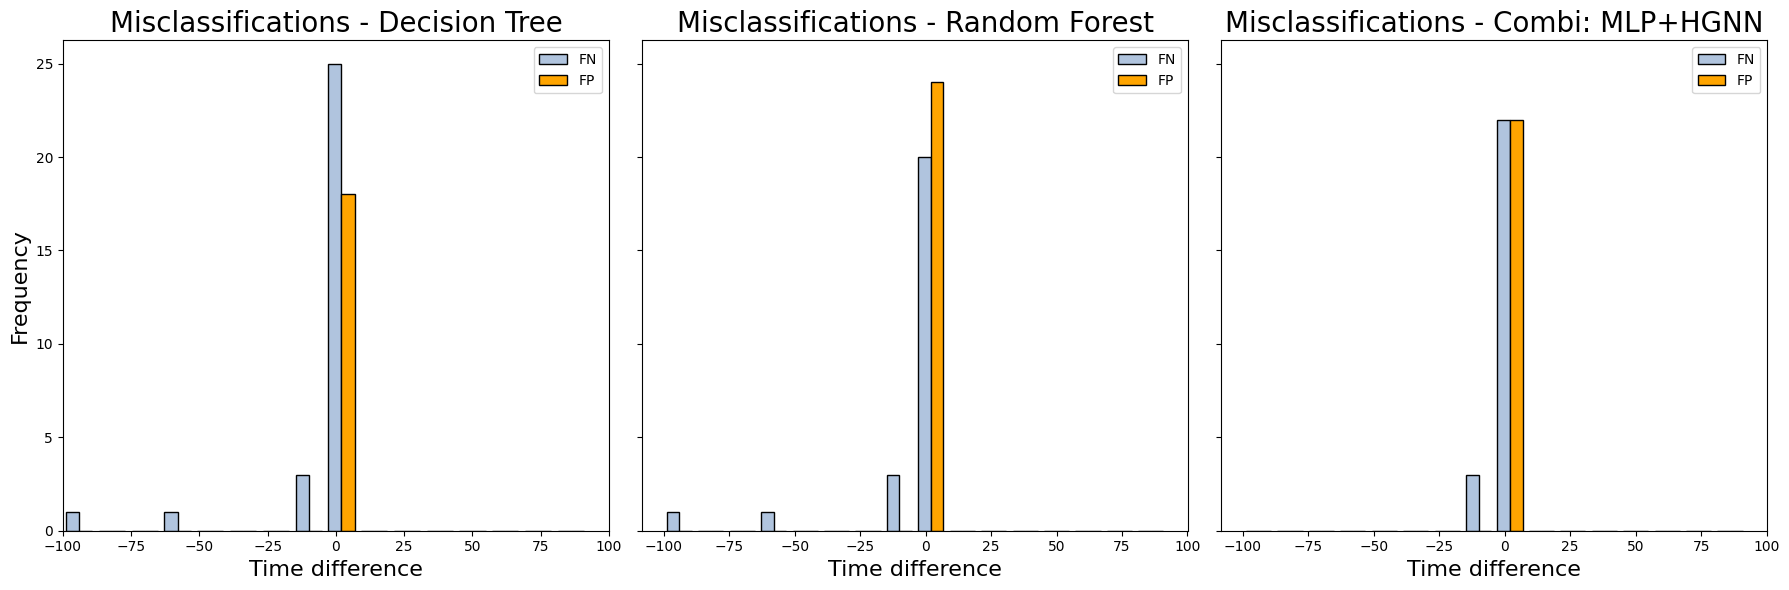

In [54]:
import matplotlib.pyplot as plt

diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']
diff_0_forest = misclass_forest[misclass_forest['pred label'] == 0]['diff rewr-orig']
diff_1_forest = misclass_forest[misclass_forest['pred label'] == 1]['diff rewr-orig']
diff_0_combi = misclass_combi[misclass_combi['pred label'] == 0]['diff rewr-orig']
diff_1_combi = misclass_combi[misclass_combi['pred label'] == 1]['diff rewr-orig']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

bins=list(range(-100, 101, 12))
axes[0].hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[0].set_xlabel('Time difference', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title('Misclassifications - Decision Tree', fontsize = 20)
axes[0].legend(title='')
axes[0].set_xlim([-100,100])
axes[1].hist([diff_0_forest, diff_1_forest], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[1].set_xlabel('Time difference', fontsize = 16)
axes[1].set_title('Misclassifications - Random Forest', fontsize = 20)
axes[1].legend(title='')
axes[2].hist([diff_0_combi, diff_1_combi], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[2].set_xlabel('Time difference', fontsize = 16)
axes[2].set_title('Misclassifications - Combi: MLP+HGNN', fontsize = 20)
axes[2].legend(title='')

plt.tight_layout()
plt.savefig("results/res_spa_mis", dpi=300)
plt.show()

## Final model on test set (with statistical tests)

We apply the final model (= the decision tree) on the untouched test set and observe the metrics and misclassifications on it (= how well it generalizes). Additionally, we compare the mean/median between the original runtimes on the test set and the decided runtimes on the test set (either the rewritten or the original one, based on the decision program).

In [40]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [56]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.8027210884353742
0.8053691275167785
0.8053691275167785


array([[116,  29],
       [ 29, 120]])

We inspect the misclassifications of this final model.

In [57]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

,pred label,true label,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,...,q75(branching factors),balancedness factor,container counts list,branching factors list,hypergraph,text,orig/rewr/equal 0.5,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01
1653,1,0,STATS,131-143-augF1-augA6,orig,orig,0.514398,0.614337,1.721684,0.099939,...,6.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[6],"Hypergraph(num_v=40, num_e=7)","SELECT MIN(u.id) FROM comments as c, posts as ...",equal,equal,orig,orig
1283,0,1,STATS,106-084-augF1-augA1,rewr,orig,0.444406,0.375596,2.261096,-0.068810,...,1.00,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","Hypergraph(num_v=17, num_e=3)","SELECT MIN(v.id) FROM comments as c, votes as ...",equal,equal,rewr,rewr
1359,0,1,STATS,112-028-augA1,rewr,orig,0.744023,0.590712,2.486703,-0.153311,...,3.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[3],"Hypergraph(num_v=25, num_e=4)","SELECT MIN(p.id) FROM votes as v, posts as p, ...",equal,rewr,rewr,rewr
1525,0,1,STATS,123-047-augF2-augA4,rewr,rewr,2.914643,0.386885,2.228317,-2.527758,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],"Hypergraph(num_v=32, num_e=5)","SELECT MIN(u.id) FROM comments as c, posts as ...",rewr,rewr,rewr,rewr
1198,0,1,STATS,097-077-augF1-augA4,rewr,orig,0.671410,0.595359,1.651878,-0.076052,...,3.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4, 1]","Hypergraph(num_v=35, num_e=6)","SELECT MIN(b.id) FROM comments as c, posts as ...",equal,equal,rewr,rewr
1684,1,0,STATS,133-052-augF2-augA1,orig,orig,0.509872,0.557117,1.660219,0.047244,...,4.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[4],"Hypergraph(num_v=29, num_e=5)","SELECT MIN(p.id) FROM comments as c, posts as ...",equal,equal,equal,orig
2692,1,0,HETIO,9-07-DuGcGpMF-augA2,orig,orig,1.923481,2.035968,3.998621,0.112487,...,2.50,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 2, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(g1.nid) FROM disease d, upregulates...",equal,orig,orig,orig
2335,0,1,JOB,20a-augF1-augA1,rewr,orig,14.335614,13.860463,16.085109,-0.475151,...,3.25,0.600000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 4, 3]","Hypergraph(num_v=51, num_e=10)",SELECT MIN(cc.id) AS complete_downey_ironman_m...,equal,rewr,rewr,rewr
1367,0,1,STATS,112-028-augF2-augA1,rewr,orig,0.702430,0.592540,2.536817,-0.109891,...,3.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[3],"Hypergraph(num_v=25, num_e=4)","SELECT MIN(p.id) FROM votes as v, posts as p, ...",equal,rewr,rewr,rewr
283,1,0,STATS,022-125-augF1,orig,orig,0.212628,0.474945,1.429150,0.262317,...,1.75,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","Hypergraph(num_v=20, num_e=4)","SELECT MIN(ph.Id) FROM postHistory as ph, vote...",equal,orig,orig,orig


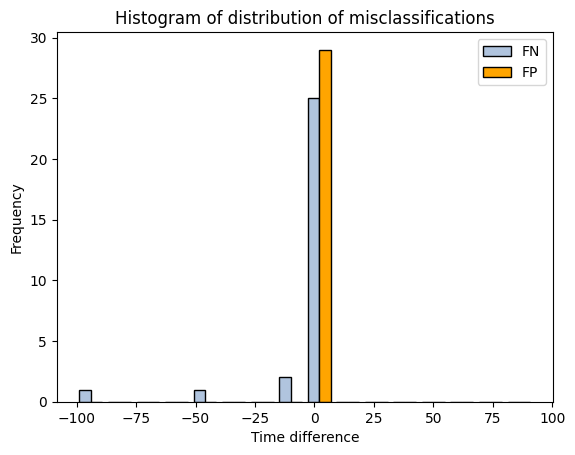

In [58]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference')
plt.ylabel('Frequency')
plt.title('Histogram of distribution of misclassifications')
plt.legend(title='')

# Show the plot
plt.show()

In [59]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_1098346/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_1098346/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut,0.01,0.1,1,10,100,TO
FP,2,15,12,0,0,0
FN,1,12,8,6,2,0


We perform the statistical tests here.

In [41]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [42]:
test_set['pred mean'] = np.where(test_set['pred label'] == 0, test_set['orig mean'], test_set['rewr mean'])
test_set.head()

,pred label,true label,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,...,balancedness factor,container counts list,branching factors list,hypergraph,text,orig/rewr/equal 0.5,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01,pred mean
574,0,0,STATS,046-128-augF1-augA4,orig,orig,0.591848,0.604455,2.668834,0.012607,...,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","Hypergraph(num_v=31, num_e=5)","SELECT MIN(v.id) FROM comments as c, posts as ...",equal,equal,equal,orig,0.591848
2086,1,1,SNAP,wiki-path07-augA2,rewr,rewr,100.000000,83.424965,85.298854,-16.575035,...,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 1, 2]","Hypergraph(num_v=16, num_e=8)","select MIN(p3.fromnode) from wiki p1, wiki p2,...",rewr,rewr,rewr,rewr,83.424965
1621,1,1,STATS,129-140-augF2,rewr,orig,0.911721,0.755924,1.982493,-0.155797,...,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[6],"Hypergraph(num_v=40, num_e=7)","SELECT MIN(c.Id) FROM comments as c, posts as ...",equal,rewr,rewr,rewr,0.755924
1653,1,0,STATS,131-143-augF1-augA6,orig,orig,0.514398,0.614337,1.721684,0.099939,...,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[6],"Hypergraph(num_v=40, num_e=7)","SELECT MIN(u.id) FROM comments as c, posts as ...",equal,equal,orig,orig,0.614337
2668,1,1,HETIO,9-03-DaGrGpMF-augA6,rewr,rewr,6.209357,1.834116,3.915546,-4.375241,...,0.666667,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3]","Hypergraph(num_v=14, num_e=7)","SELECT MIN(mf.nid) FROM disease d, associates ...",rewr,rewr,rewr,rewr,1.834116


The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [62]:
w_stat, p_val = stats.wilcoxon(test_set["orig mean"], test_set["pred mean"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 696.0
P-value: 1.8638497960501474e-20


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [63]:
t_stat, p_val = stats.ttest_rel(test_set["orig mean"], test_set["pred mean"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 7.0012538442327275
P-value: 1.7362171226801174e-11


Finally, we inspect the decision tree as graphic and provide the feature importances (based on the Gini importance) for all features.

In [64]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

,#relations,#conditions,#filters,#joins,depth,min(container counts),max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors)
Importance,0.063368,0.120211,0.393823,0.044418,0.004182,0.0,0.061582,0.270023,0.0,0.0,0.0,0.003849,0.003813,0.001634,0.010049,0.004131,0.018918


In [65]:
df_importances

,Importance
#relations,0.063368
#conditions,0.120211
#filters,0.393823
#joins,0.044418
depth,0.004182
min(container counts),0.000000
max(container counts),0.061582
mean(container counts),0.270023
q25(container counts),0.000000
median(container counts),0.000000


In [66]:
clf.tree_.max_depth

17

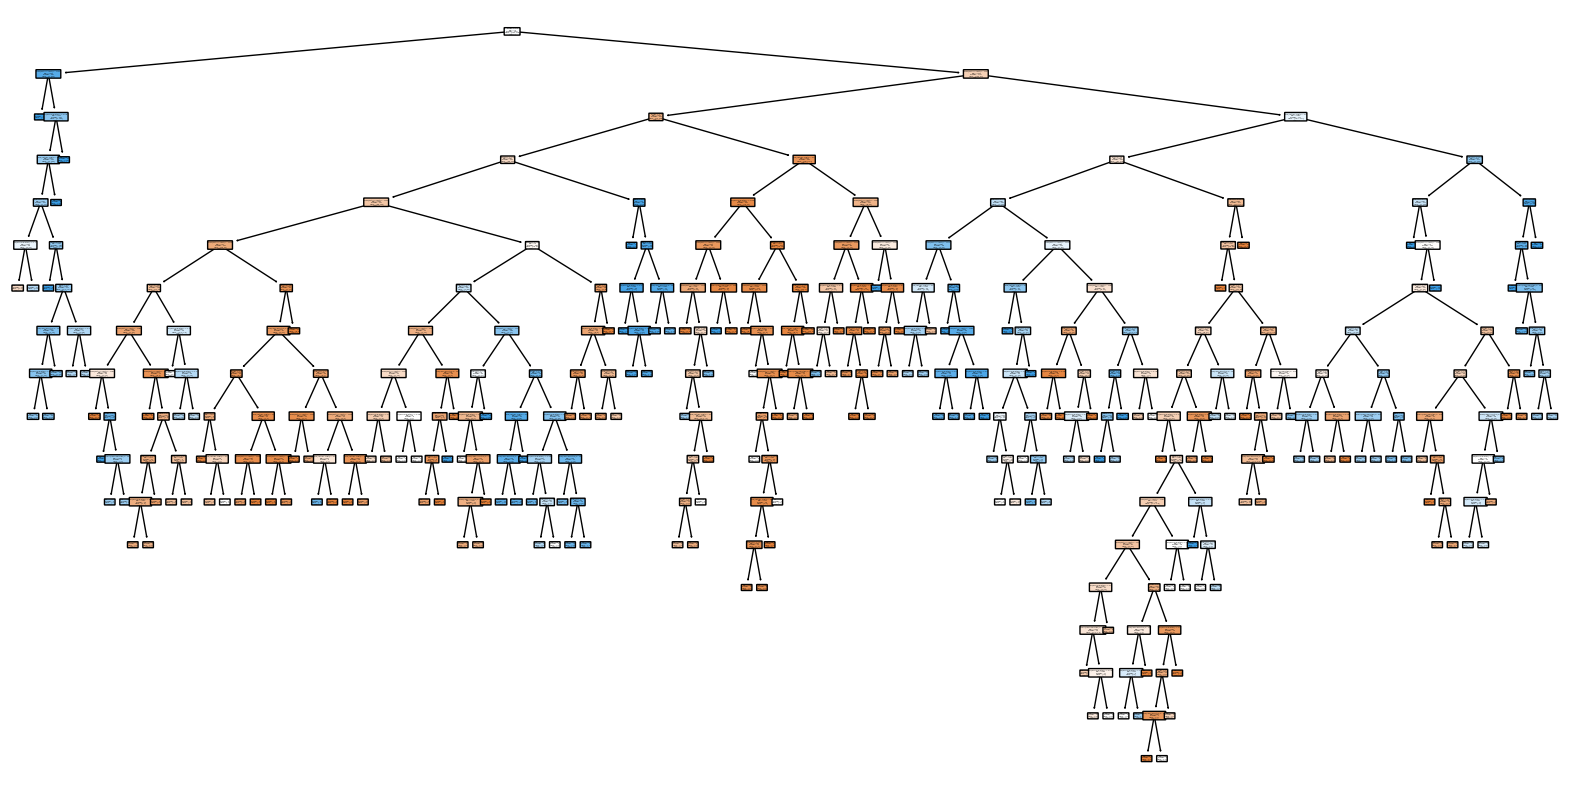

In [67]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.show()

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_1422/3989257457.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_1422/3989257457.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_1422/3989257457.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

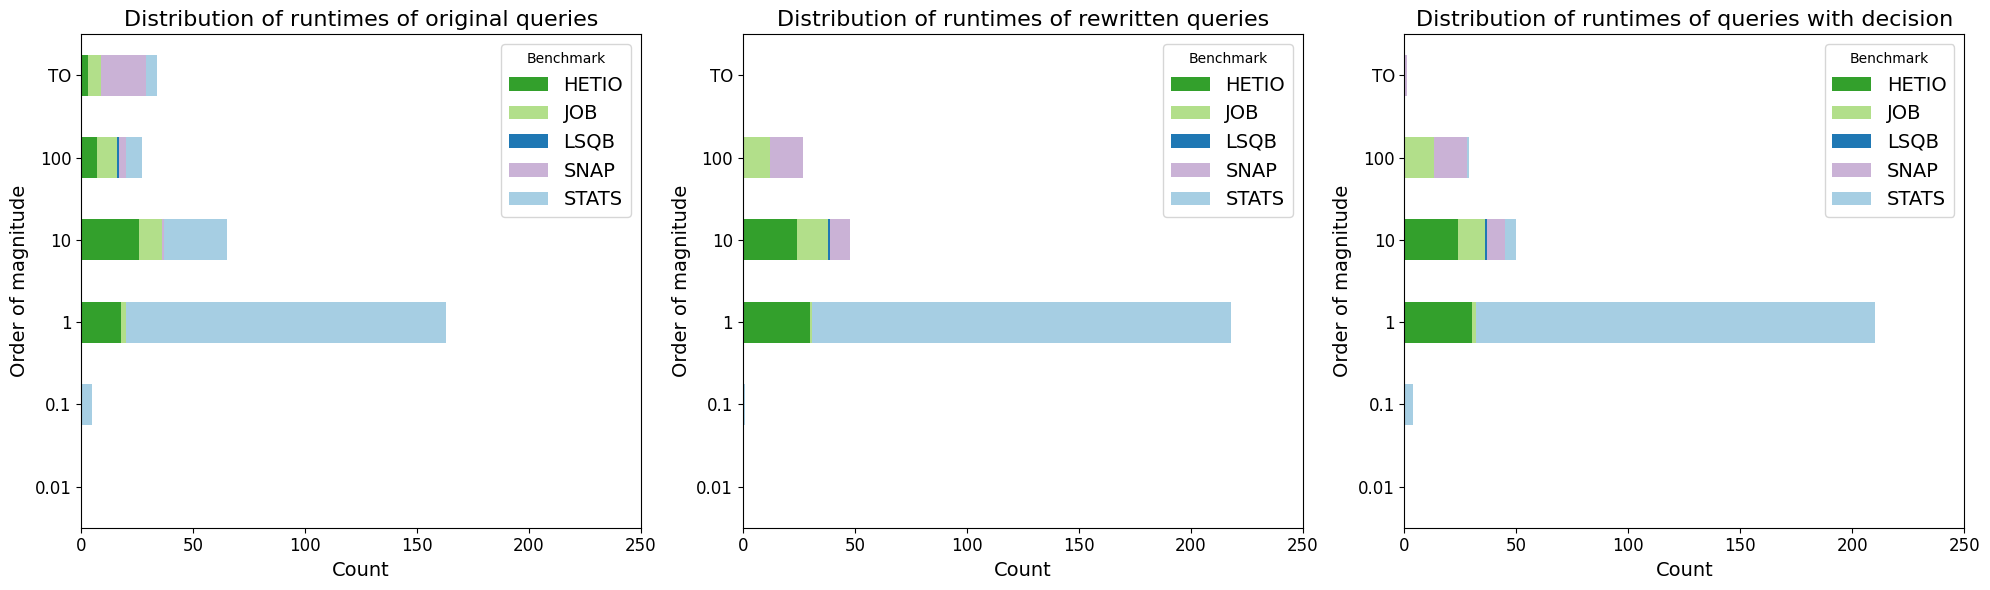

In [43]:
test_set["orig mean"] = test_set['orig mean'].astype("float64")
test_set["rewr mean"] = test_set['rewr mean'].astype("float64")
test_set["pred mean"] = test_set['pred mean'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig mean'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr mean'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred mean'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlim(0,250)
ax1.set_xlabel('Count', fontsize=14)  # Increase font size for x-axis label
ax1.set_ylabel('Order of magnitude', fontsize=14)  # Increase font size for y-axis label
ax1.set_title('Distribution of runtimes of original queries', fontsize=16)  # Increase font size for title
ax1.legend(title='Benchmark', fontsize=14)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Order of magnitude', fontsize=14)
ax2.set_title('Distribution of runtimes of rewritten queries', fontsize=16)
ax2.legend(title='Benchmark', fontsize=14)  
ax2.set_xlim(0,250)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3)
ax3.set_xlabel('Count', fontsize=14)
ax3.set_ylabel('Order of magnitude', fontsize=14)
ax3.set_title('Distribution of runtimes of queries with decision', fontsize=16)
ax3.legend(title='Benchmark', fontsize=14)  
ax3.set_xlim(0,250)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

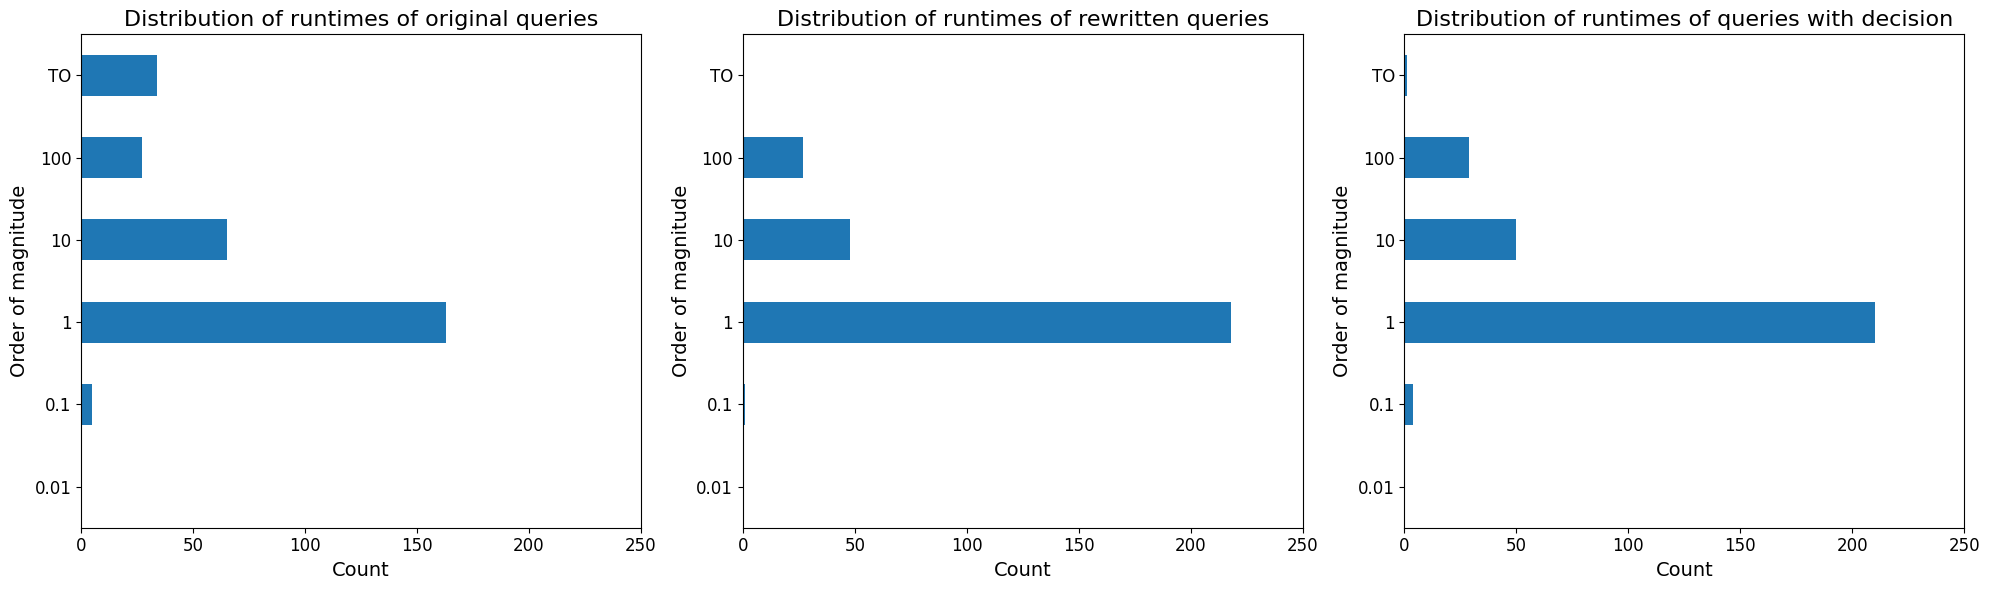

In [44]:
test_set["orig mean"] = test_set['orig mean'].astype("float64")
test_set["rewr mean"] = test_set['rewr mean'].astype("float64")
test_set["pred mean"] = test_set['pred mean'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig mean'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr mean'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred mean'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1)
ax1.set_xlim(0,250)
ax1.set_xlabel('Count', fontsize=14)  # Increase font size for x-axis label
ax1.set_ylabel('Order of magnitude', fontsize=14)  # Increase font size for y-axis label
ax1.set_title('Distribution of runtimes of original queries', fontsize=16)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Order of magnitude', fontsize=14)
ax2.set_title('Distribution of runtimes of rewritten queries', fontsize=16)
ax2.set_xlim(0,250)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3)
ax3.set_xlabel('Count', fontsize=14)
ax3.set_ylabel('Order of magnitude', fontsize=14)
ax3.set_title('Distribution of runtimes of queries with decision', fontsize=16)
ax3.set_xlim(0,250)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()